#### Oğuz Deniz 201401011
##### YAP441 Project - Markov Models Approaches Notebook

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from hmmlearn import hmm
import ta 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [18]:
data = pd.read_csv('BAC.csv')
data

Date       Open       High        Low      Close  Adj Close  \
0     2005-01-03  46.660000  46.950001  46.180000  46.459999  30.944794   
1     2005-01-04  46.410000  46.730000  45.740002  45.820000  30.518513   
2     2005-01-05  45.639999  45.939999  45.250000  45.290001  30.165506   
3     2005-01-06  45.419998  45.630001  44.990002  45.220001  30.118887   
4     2005-01-07  45.299999  45.360001  44.720001  44.730000  29.792515   
...          ...        ...        ...        ...        ...        ...   
4526  2022-12-23  32.400002  32.580002  32.189999  32.470001  32.005371   
4527  2022-12-27  32.500000  32.669998  32.279999  32.529999  32.064510   
4528  2022-12-28  32.570000  32.970001  32.529999  32.770000  32.301079   
4529  2022-12-29  32.889999  33.160000  32.750000  33.139999  32.665783   
4530  2022-12-30  33.099998  33.299999  32.860001  33.119999  32.646065   

        Volume  
0     10238100  
1     10264100  
2     14796100  
3     14602200  
4     10547200  
...        ...  
4526  21378600  
4527  22776100  
4528  30541000  
4529  22252900  
4530  28198900  

[4531 rows x 7 columns]

In [19]:
data.describe()

Open         High          Low        Close    Adj Close  \
count  4531.000000  4531.000000  4531.000000  4531.000000  4531.000000   
mean     26.128713    26.420113    25.813975    26.109839    21.707382   
std      13.749759    13.832501    13.664766    13.749975    10.819741   
min       3.220000     3.510000     2.530000     3.140000     2.591577   
25%      14.740000    14.910000    14.530000    14.730000    12.380632   
50%      23.920000    24.230000    23.620001    23.920000    21.237963   
75%      37.080000    37.645000    36.519998    37.070000    30.784658   
max      55.040001    55.080002    54.820000    54.900002    47.565868   

             Volume  
count  4.531000e+03  
mean   1.010425e+08  
std    1.050944e+08  
min    4.520100e+06  
25%    4.126650e+07  
50%    6.870870e+07  
75%    1.239726e+08  
max    1.226791e+09

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4531 entries, 0 to 4530
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4531 non-null   object 
 1   Open       4531 non-null   float64
 2   High       4531 non-null   float64
 3   Low        4531 non-null   float64
 4   Close      4531 non-null   float64
 5   Adj Close  4531 non-null   float64
 6   Volume     4531 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 247.9+ KB


In [21]:
class StockHMMPredictor:
    def __init__(self, n_states=2):
        self.n_states = n_states
        self.scaler = StandardScaler()
        self.hmm_model = hmm.GaussianHMM(
            n_components=n_states, 
            covariance_type="full", 
            n_iter=100
        )
        
    def prepare_data(self, data):
        # Calculate daily returns and other features
        df = data.copy()
        df['Returns'] = df['Adj Close'].pct_change()
        df['Volume_Change'] = df['Volume'].pct_change()
        df['High_Low_Diff'] = df['High'] - df['Low']
        df['Open_Close_Diff'] = df['Close'] - df['Open']
        
        # Create feature matrix
        features = ['Returns', 'Volume_Change', 'High_Low_Diff', 'Open_Close_Diff']
        X = df[features].dropna()
        
        # Scale the features
        X_scaled = self.scaler.fit_transform(X)
        return X_scaled, df
    
    def prepare_weekly_data(self, data):
        # Make a copy of the data
        df = data.copy()
        
        # Ensure Date is datetime
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
        
        # Resample data to weekly frequency
        weekly_data = df.resample('W').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Adj Close': 'last',
            'Volume': 'sum'
        })
        
        return self.prepare_data(weekly_data)
    
    def train(self, X):
        self.hmm_model.fit(X)
        
    def predict_next_state(self, X):
        hidden_states = self.hmm_model.predict(X)
        last_state = hidden_states[-1]
        next_state_probs = self.hmm_model.transmat_[last_state]
        predicted_state = np.argmax(next_state_probs)
        return predicted_state, next_state_probs, hidden_states

    def predict_direction(self, X, df):
        # Get state sequence
        _, _, hidden_states = self.predict_next_state(X)
        
        # Calculate returns for the same period as X
        returns = df['Returns'].iloc[-len(hidden_states):]
        
        # Calculate average returns for each state
        state_returns = {}
        for state in range(self.n_states):
            mask = hidden_states == state
            state_returns[state] = returns[mask].mean()
        
        # Predict next state
        predicted_state, state_probs, _ = self.predict_next_state(X)
        
        # Predict direction based on the average returns of predicted state
        predicted_direction = "Up" if state_returns[predicted_state] > 0 else "Down"
        confidence = state_probs[predicted_state]
        
        return predicted_direction, confidence, state_returns, hidden_states

In [22]:
class StockHMMPredictorWIndicators:
    def __init__(self, n_states=2):
        self.n_states = n_states
        self.scaler = StandardScaler()
        self.hmm_model = hmm.GaussianHMM(
            n_components=n_states, 
            covariance_type="full", 
            n_iter=100
        )
        
    def prepare_data(self, data):
        # Calculate basic features
        df = data.copy()
        df['Returns'] = df['Adj Close'].pct_change()
        df['Volume_Change'] = df['Volume'].pct_change()
        df['High_Low_Diff'] = df['High'] - df['Low']
        df['Open_Close_Diff'] = df['Close'] - df['Open']
        
        # --- Add technical analysis indicators ---
        # Simple Moving Average (SMA) for 10 days
        df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
        
        # Relative Strength Index (RSI) for 14 days using the ta library
        df['RSI'] = ta.momentum.RSIIndicator(df['Adj Close'], window=14).rsi()
        
        # MACD: Using default parameters (fast=12, slow=26, signal=9)
        macd_indicator = ta.trend.MACD(df['Adj Close'])
        df['MACD'] = macd_indicator.macd()
        
        # --- End technical indicators ---

        # Create feature matrix using both the original and technical features
        features = [
            'Returns', 
            'Volume_Change', 
            'High_Low_Diff', 
            'Open_Close_Diff',
            'SMA_10',
            'RSI',
            'MACD'
        ]
        
        # Drop rows with any missing values (from pct_change, rolling, etc.)
        X = df[features].dropna()
        
        # Scale the features
        X_scaled = self.scaler.fit_transform(X)
        return X_scaled, df
    
    def prepare_weekly_data(self, data):
        # Make a copy of the data
        df = data.copy()
        
        # Ensure Date is datetime and set as index if needed
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
        
        # Resample data to weekly frequency
        weekly_data = df.resample('W').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Adj Close': 'last',
            'Volume': 'sum'
        })
        
        return self.prepare_data(weekly_data)
    
    def train(self, X):
        self.hmm_model.fit(X)
        
    def predict_next_state(self, X):
        hidden_states = self.hmm_model.predict(X)
        last_state = hidden_states[-1]
        next_state_probs = self.hmm_model.transmat_[last_state]
        predicted_state = np.argmax(next_state_probs)
        return predicted_state, next_state_probs, hidden_states

    def predict_direction(self, X, df):
        # Get state sequence
        _, _, hidden_states = self.predict_next_state(X)
        
        # Calculate returns for the same period as X
        returns = df['Returns'].iloc[-len(hidden_states):]
        
        # Calculate average returns for each state
        state_returns = {}
        for state in range(self.n_states):
            mask = hidden_states == state
            state_returns[state] = returns[mask].mean()
        
        # Predict next state
        predicted_state, state_probs, _ = self.predict_next_state(X)
        
        # Predict direction based on the average returns of the predicted state
        predicted_direction = "Up" if state_returns[predicted_state] > 0 else "Down"
        confidence = state_probs[predicted_state]
        
        return predicted_direction, confidence, state_returns, hidden_states

In [23]:
class StockHMMVisualizer:
    @staticmethod
    def plot_states_and_prices(df, hidden_states, n_states, prediction_type="daily"):
        plt.figure(figsize=(15, 10))
        
        # Create subplots
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)
        
        # Align the x-axis with the length of hidden_states:
        x_axis = df.index[-len(hidden_states):]
        
        # Plot adjusted close prices using the aligned x_axis
        ax1.plot(x_axis, df.loc[x_axis, 'Adj Close'], label='Adjusted Close Price', color='black', alpha=0.8)
        ax1.set_title(f'{prediction_type.capitalize()} Adjusted Close Price with HMM States (n_states={n_states})')
        ax1.set_ylabel('Price')
        
        # Use a color palette for states
        colors = plt.cm.rainbow(np.linspace(0, 1, n_states))
        for i in range(n_states):
            mask = (hidden_states == i)
            ax1.fill_between(
                x_axis, 
                df.loc[x_axis, 'Adj Close'].min(), 
                df.loc[x_axis, 'Adj Close'].max(),
                where=mask,
                color=colors[i],
                alpha=0.1,
                label=f'State {i}'
            )
        ax1.legend()
        
        # Plot returns using the same x_axis
        ax2.plot(x_axis, df.loc[x_axis, 'Returns'], label='Returns', color='black', alpha=0.6)
        ax2.set_title(f'{prediction_type.capitalize()} Returns with HMM States')
        ax2.set_ylabel('Returns')
        for i in range(n_states):
            mask = (hidden_states == i)
            ax2.fill_between(
                x_axis, 
                df.loc[x_axis, 'Returns'].min(), 
                df.loc[x_axis, 'Returns'].max(),
                where=mask,
                color=colors[i],
                alpha=0.1
            )
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_state_transitions(hmm_model, n_states):
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            hmm_model.transmat_,
            annot=True,
            cmap='YlOrRd',
            fmt='.2f',
            xticklabels=[f'State {i}' for i in range(n_states)],
            yticklabels=[f'State {i}' for i in range(n_states)]
        )
        plt.title('State Transition Probabilities')
        plt.xlabel('To State')
        plt.ylabel('From State')
        plt.show()

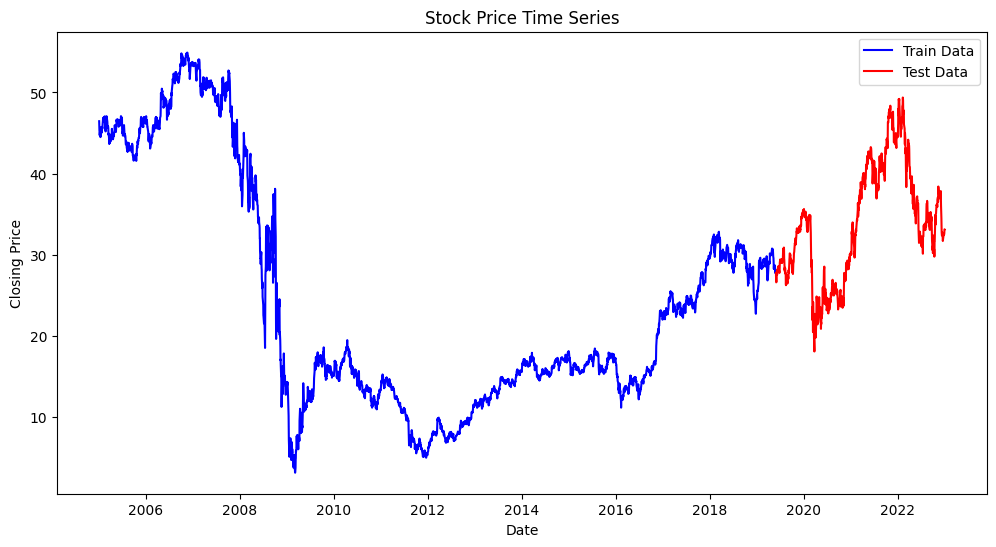

In [24]:
data = pd.read_csv("BAC.csv", parse_dates=["Date"], index_col="Date")

# Split into train and test
split_idx = int(len(data) * 0.8)
train_data = data[:split_idx]
test_data = data[split_idx:]

# Plot the train and test data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data["Close"], label="Train Data", color="blue")
plt.plot(test_data.index, test_data["Close"], label="Test Data", color="red")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Price Time Series")
plt.legend()
plt.show()

In [25]:
def calculate_accuracy_metrics(hidden_states, df):
    # Align returns with hidden states
    returns = df['Returns'].iloc[-len(hidden_states):]

    actual_directions = (returns > 0).astype(int)
    
    # Get state-wise average returns
    unique_states = np.unique(hidden_states)  # Ensure we only iterate over actual states
    state_directions = {}

    for state in unique_states:
        mask = hidden_states == state
        state_returns_mean = returns[mask].mean()
        state_directions[state] = 1 if state_returns_mean > 0 else 0
    
    # Fix: Use `.get(state, default_value)` to prevent KeyError
    predicted_directions = np.array([state_directions.get(state, 0) for state in hidden_states])
    
    # Calculate metrics
    accuracy = np.mean(predicted_directions == actual_directions)
    
    # Calculate precision, recall, and f1 for "up" movement (1)
    true_pos = np.sum((predicted_directions == 1) & (actual_directions == 1))
    false_pos = np.sum((predicted_directions == 1) & (actual_directions == 0))
    false_neg = np.sum((predicted_directions == 0) & (actual_directions == 1))
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }


def evaluate_predictions(data, prediction_type="daily", n_states=2, test_size=0.2, w_indicators = False, visualize = True):
    # Convert date to datetime and set as index if not already done
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
    
    # Initialize predictor
    if w_indicators:
        predictor = StockHMMPredictorWIndicators(n_states=n_states)
    else:
        predictor = StockHMMPredictor(n_states=n_states)
    
    # Prepare data based on prediction type
    if prediction_type == "weekly":
        X, df = predictor.prepare_weekly_data(data)
    else:
        X, df = predictor.prepare_data(data)
    
    # Calculate split point
    split_idx = int(len(X) * (1 - test_size))
    
    # Split the data
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]
    
    # Train model on training data
    predictor.train(X_train)
    
    # Get predictions for both train and test sets
    train_direction, train_confidence, train_state_returns, train_hidden_states = predictor.predict_direction(X_train, df_train)
    test_direction, test_confidence, test_state_returns, test_hidden_states = predictor.predict_direction(X_test, df_test)
    
    # Calculate metrics for both sets
    train_metrics = calculate_accuracy_metrics(train_hidden_states, df_train)
    test_metrics = calculate_accuracy_metrics(test_hidden_states, df_test)
    
    # Print results
    print(f"\nResults for {prediction_type.capitalize()} Prediction (n_states={n_states}):")
    print(f"\nTraining Set Metrics:")
    for metric, value in train_metrics.items():
        print(f"{metric.capitalize()}: {value:.2%}")
    
    print(f"\nTest Set Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric.capitalize()}: {value:.2%}")
    
    print(f"\nPredicted Direction (Test Set): {test_direction}")
    print(f"Confidence: {test_confidence:.2%}")
    print("\nState Analysis (Test Set):")
    for state, ret in test_state_returns.items():
        print(f"State {state} Average Return: {ret:.2%}")
    
    if visualize:
        # Create visualizations
        visualizer = StockHMMVisualizer()
        
        # Plot training set
        plt.figure(figsize=(15, 10))
        plt.suptitle("Training Set")
        visualizer.plot_states_and_prices(df_train, train_hidden_states, n_states, prediction_type)
        
        # Plot test set
        plt.figure(figsize=(15, 10))
        plt.suptitle("Test Set")
        visualizer.plot_states_and_prices(df_test, test_hidden_states, n_states, prediction_type)
        
        # Plot transition matrix
        visualizer.plot_state_transitions(predictor.hmm_model, n_states)
    
    return {
        'predictor': predictor,
        'X_train': X_train,
        'X_test': X_test,
        'df_train': df_train,
        'df_test': df_test,
        'train_hidden_states': train_hidden_states,
        'test_hidden_states': test_hidden_states,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }


Results for Daily Prediction (n_states=2):

Training Set Metrics:
Accuracy: 51.79%
Precision: 50.84%
Recall: 82.41%
F1_score: 62.89%

Test Set Metrics:
Accuracy: 51.21%
Precision: 51.21%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 93.20%

State Analysis (Test Set):
State 0 Average Return: 0.11%
State 1 Average Return: 0.00%


<Figure size 1500x1000 with 0 Axes>

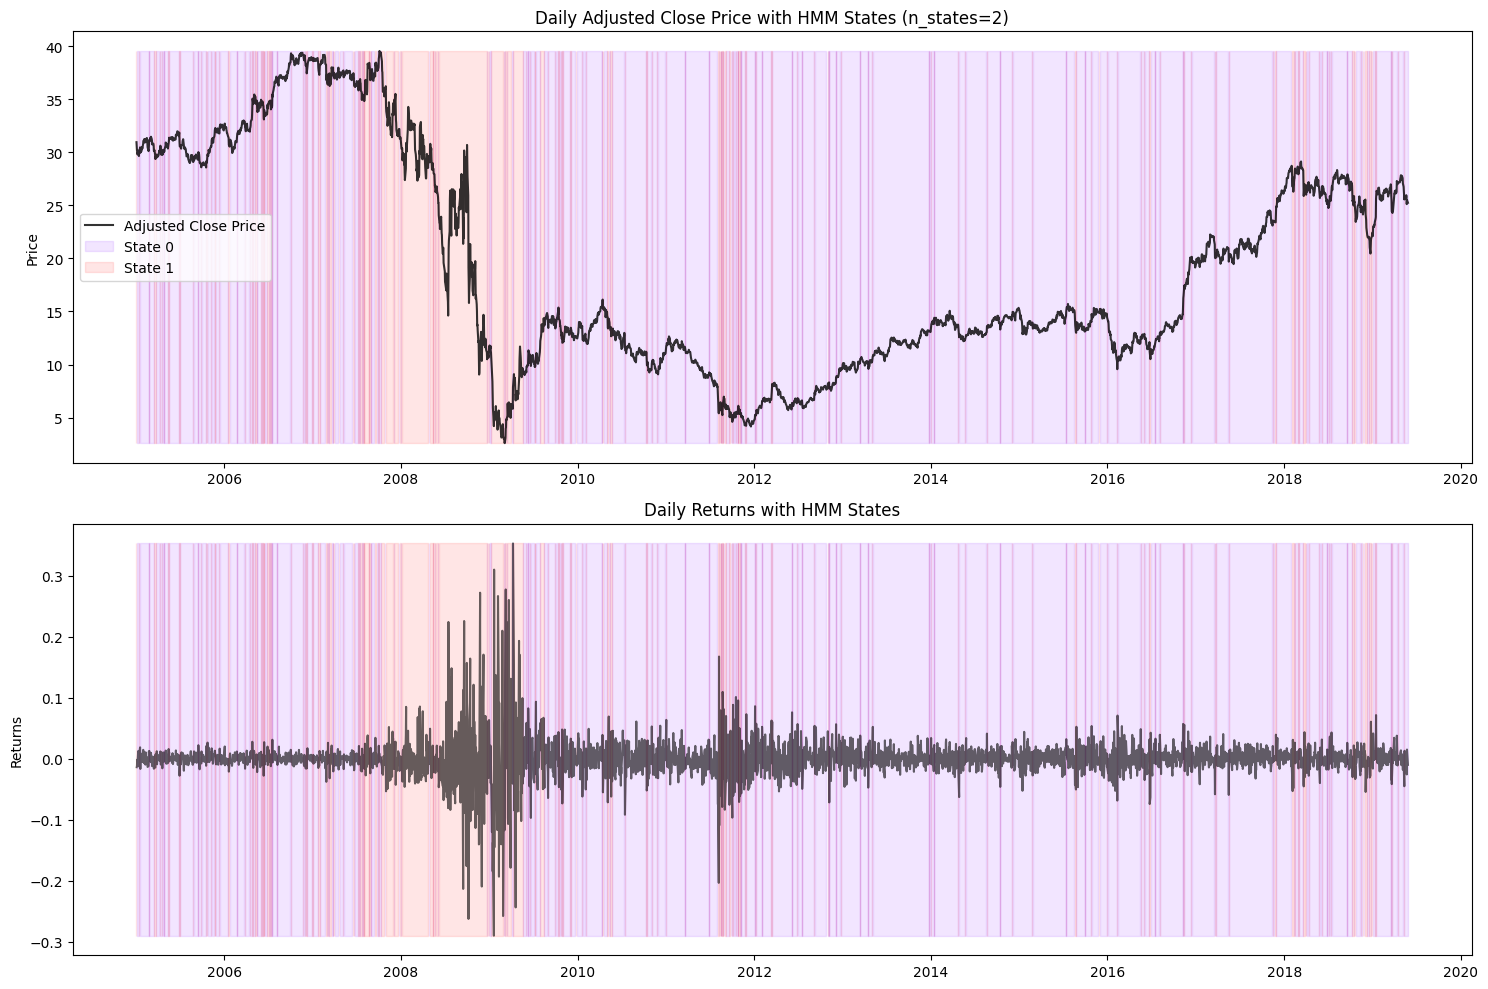

<Figure size 1500x1000 with 0 Axes>

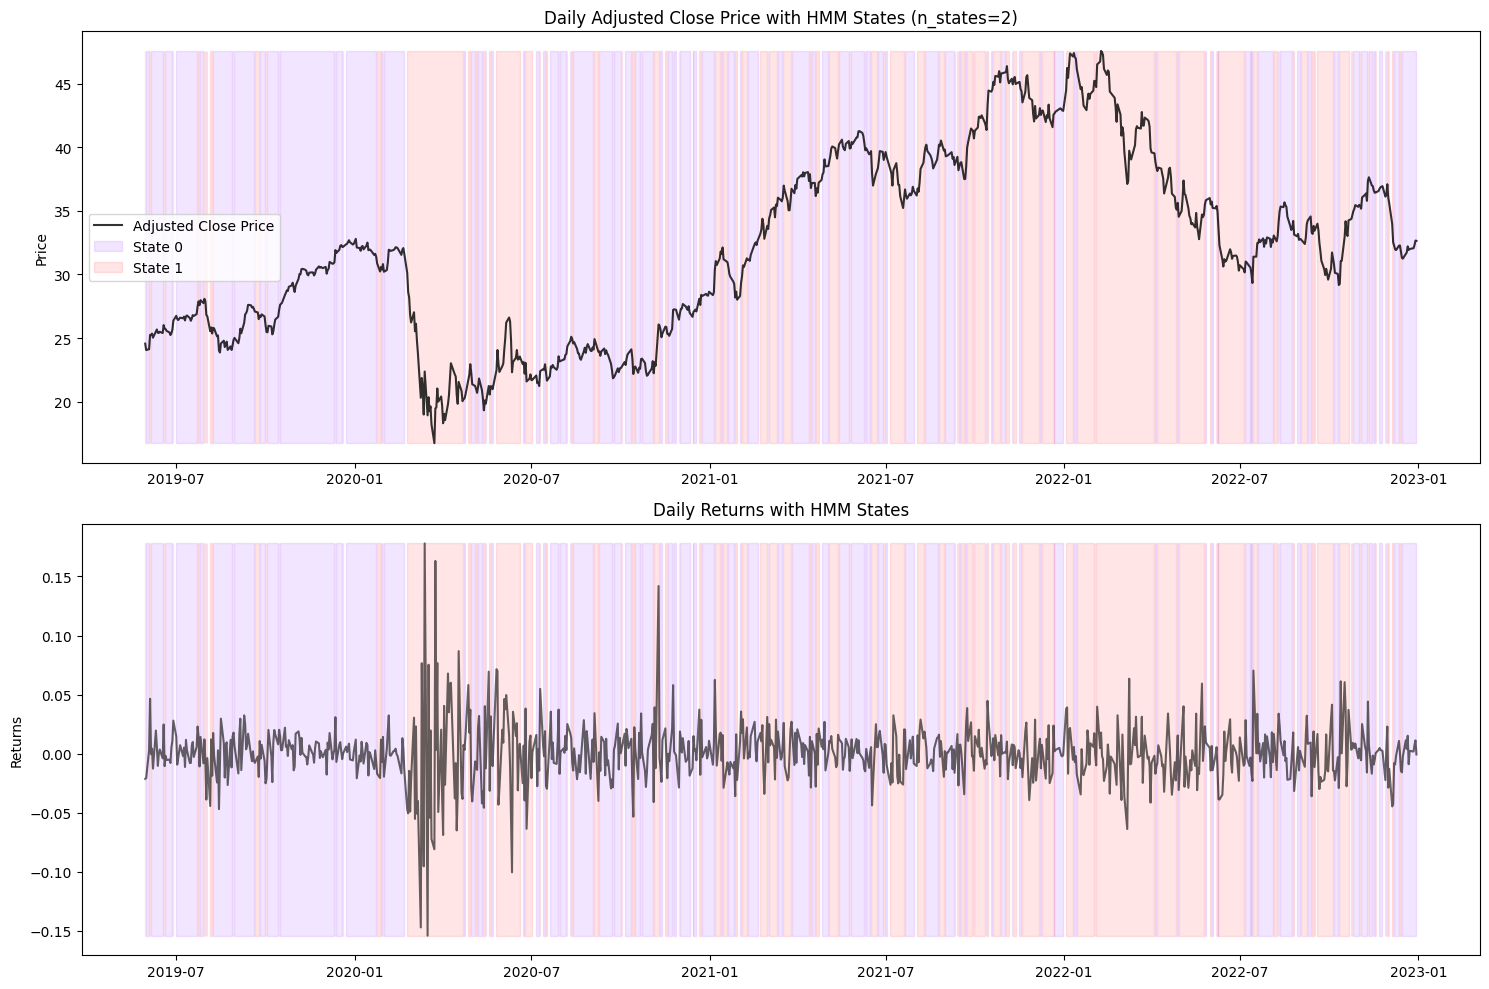

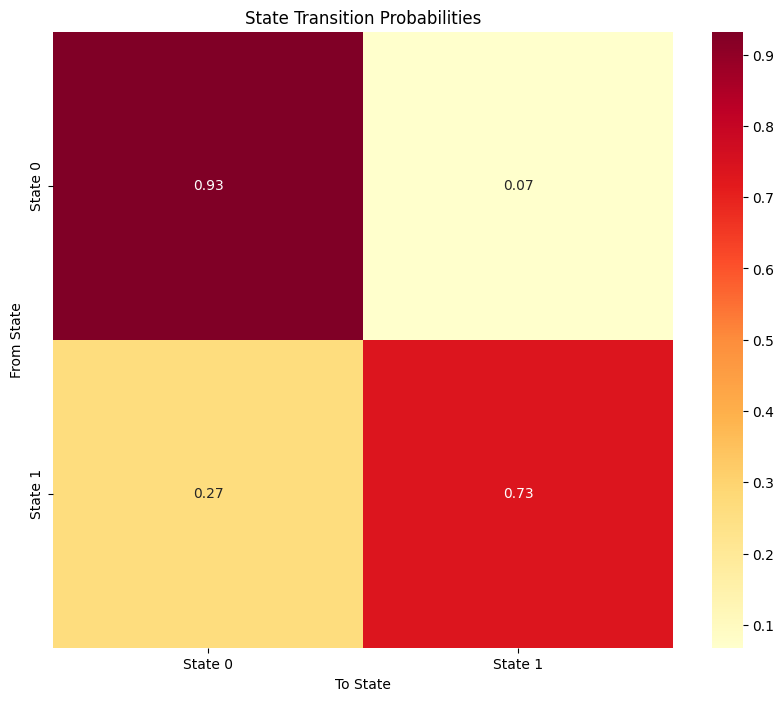


Results for Daily Prediction (n_states=3):

Training Set Metrics:
Accuracy: 51.05%
Precision: 50.55%
Recall: 56.01%
F1_score: 53.14%

Test Set Metrics:
Accuracy: 53.53%
Precision: 53.23%
Recall: 76.29%
F1_score: 62.71%

Predicted Direction (Test Set): Up
Confidence: 90.02%

State Analysis (Test Set):
State 0 Average Return: 0.34%
State 1 Average Return: -0.05%
State 2 Average Return: 0.08%


<Figure size 1500x1000 with 0 Axes>

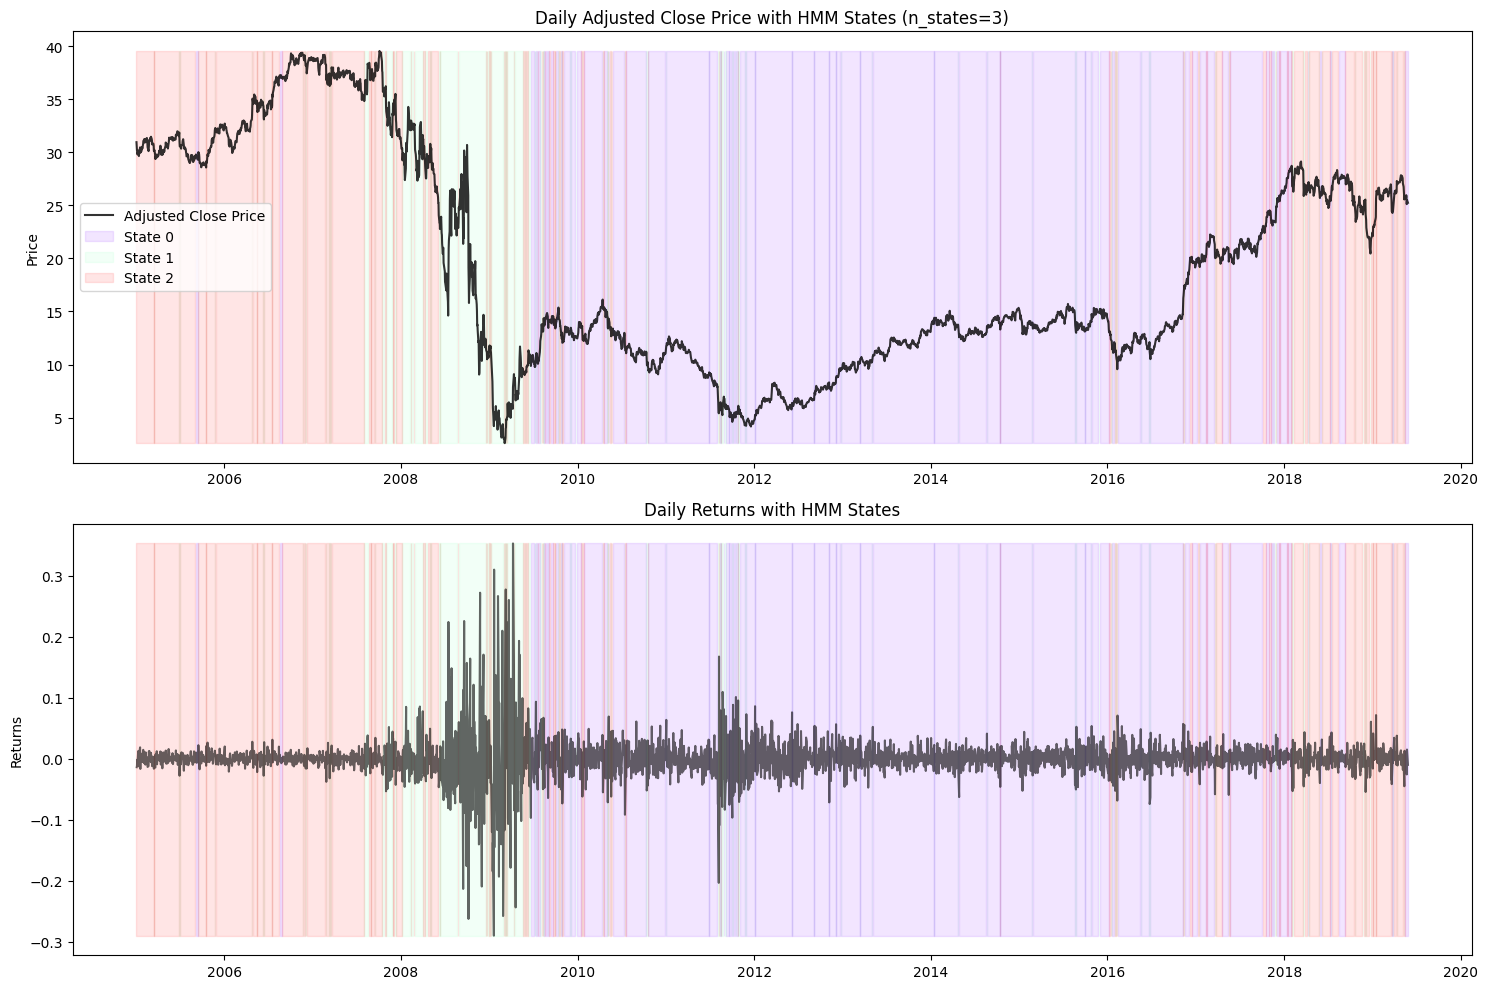

<Figure size 1500x1000 with 0 Axes>

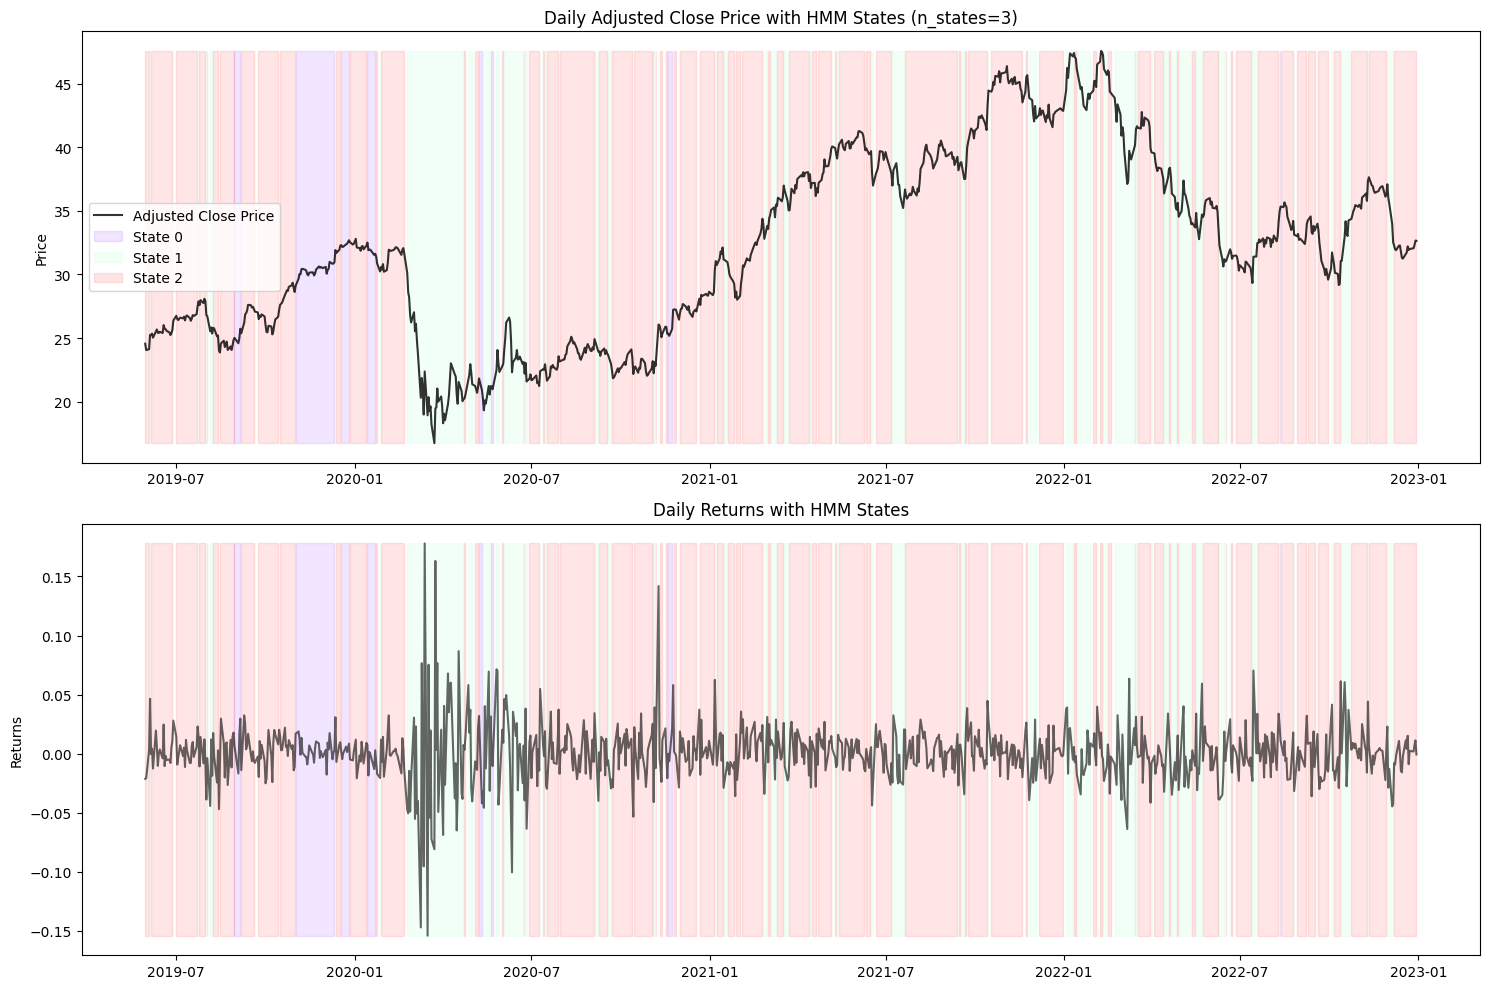

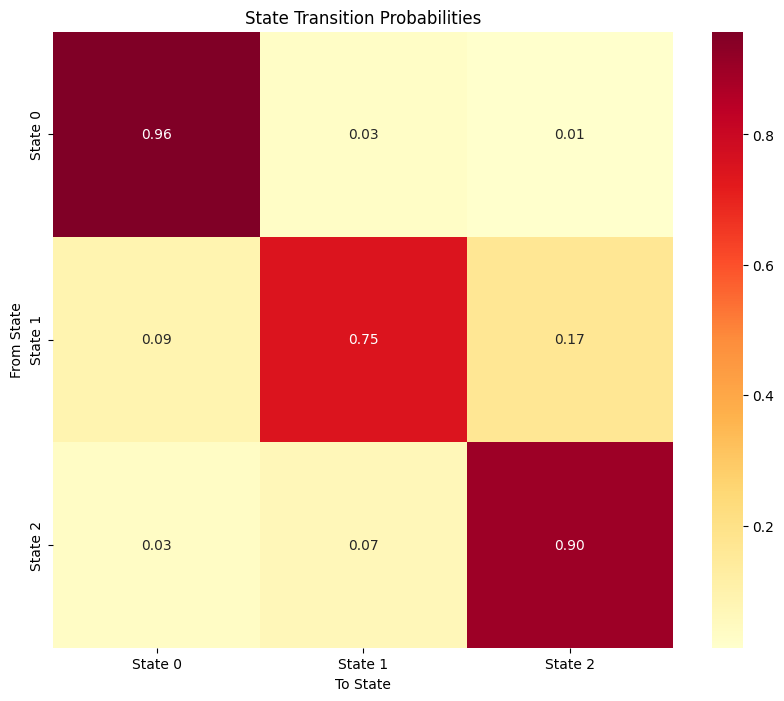


Results for Daily Prediction (n_states=4):

Training Set Metrics:
Accuracy: 50.72%
Precision: 50.23%
Recall: 60.86%
F1_score: 55.04%

Test Set Metrics:
Accuracy: 53.75%
Precision: 53.37%
Recall: 76.72%
F1_score: 62.95%

Predicted Direction (Test Set): Up
Confidence: 91.60%

State Analysis (Test Set):
State 0 Average Return: 0.12%
State 1 Average Return: -0.07%
State 2 Average Return: 0.11%
State 3 Average Return: 0.02%


<Figure size 1500x1000 with 0 Axes>

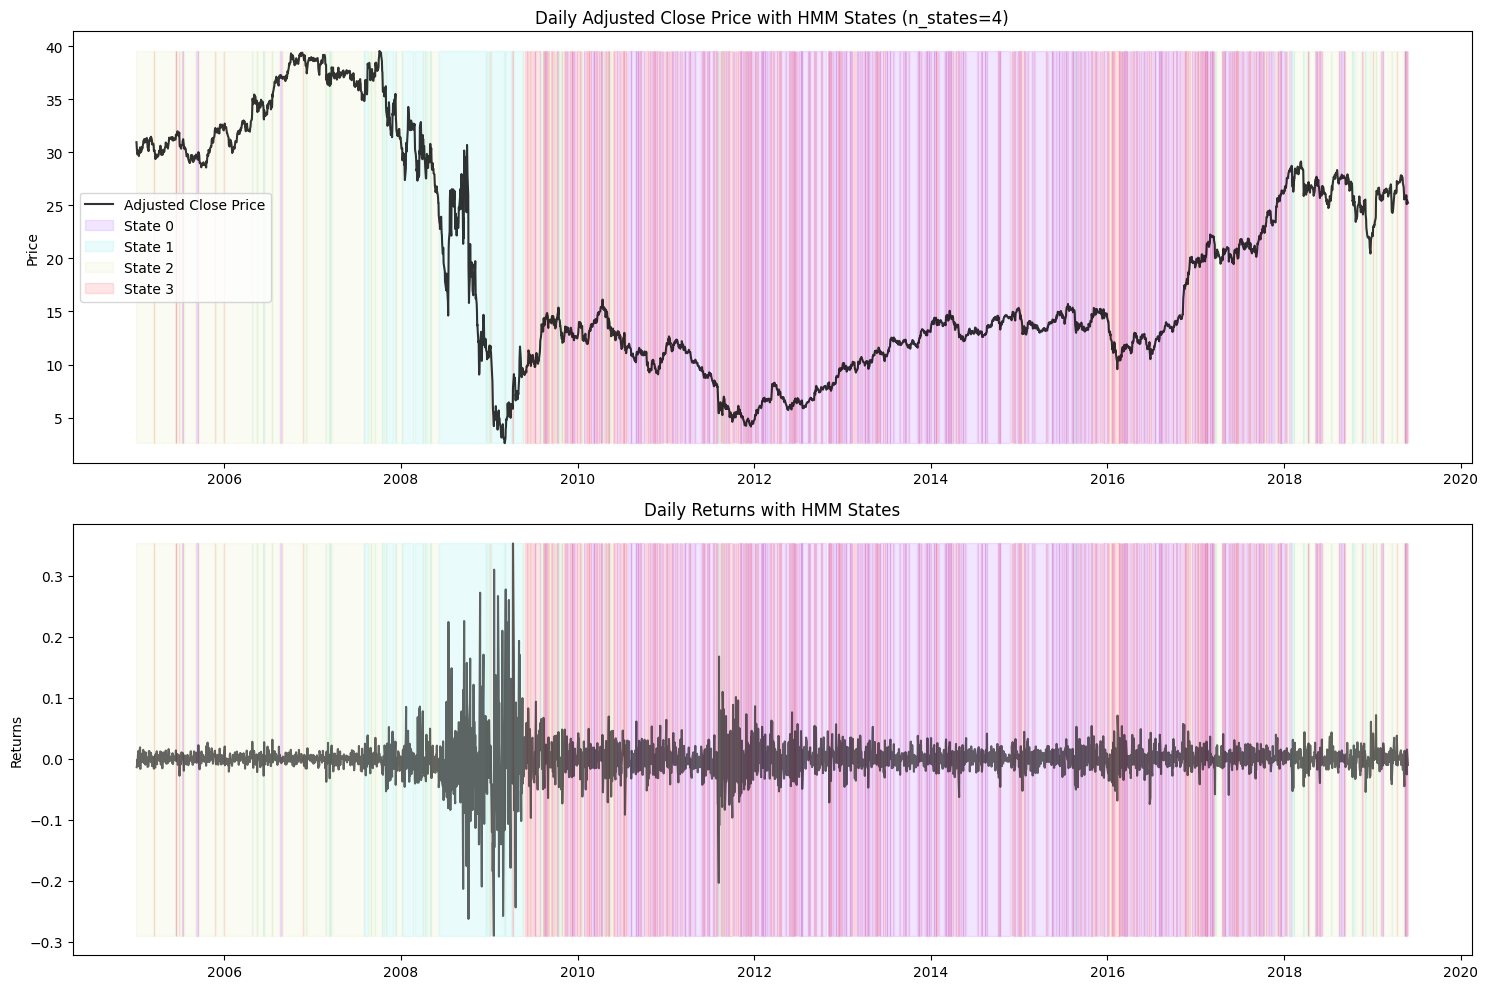

<Figure size 1500x1000 with 0 Axes>

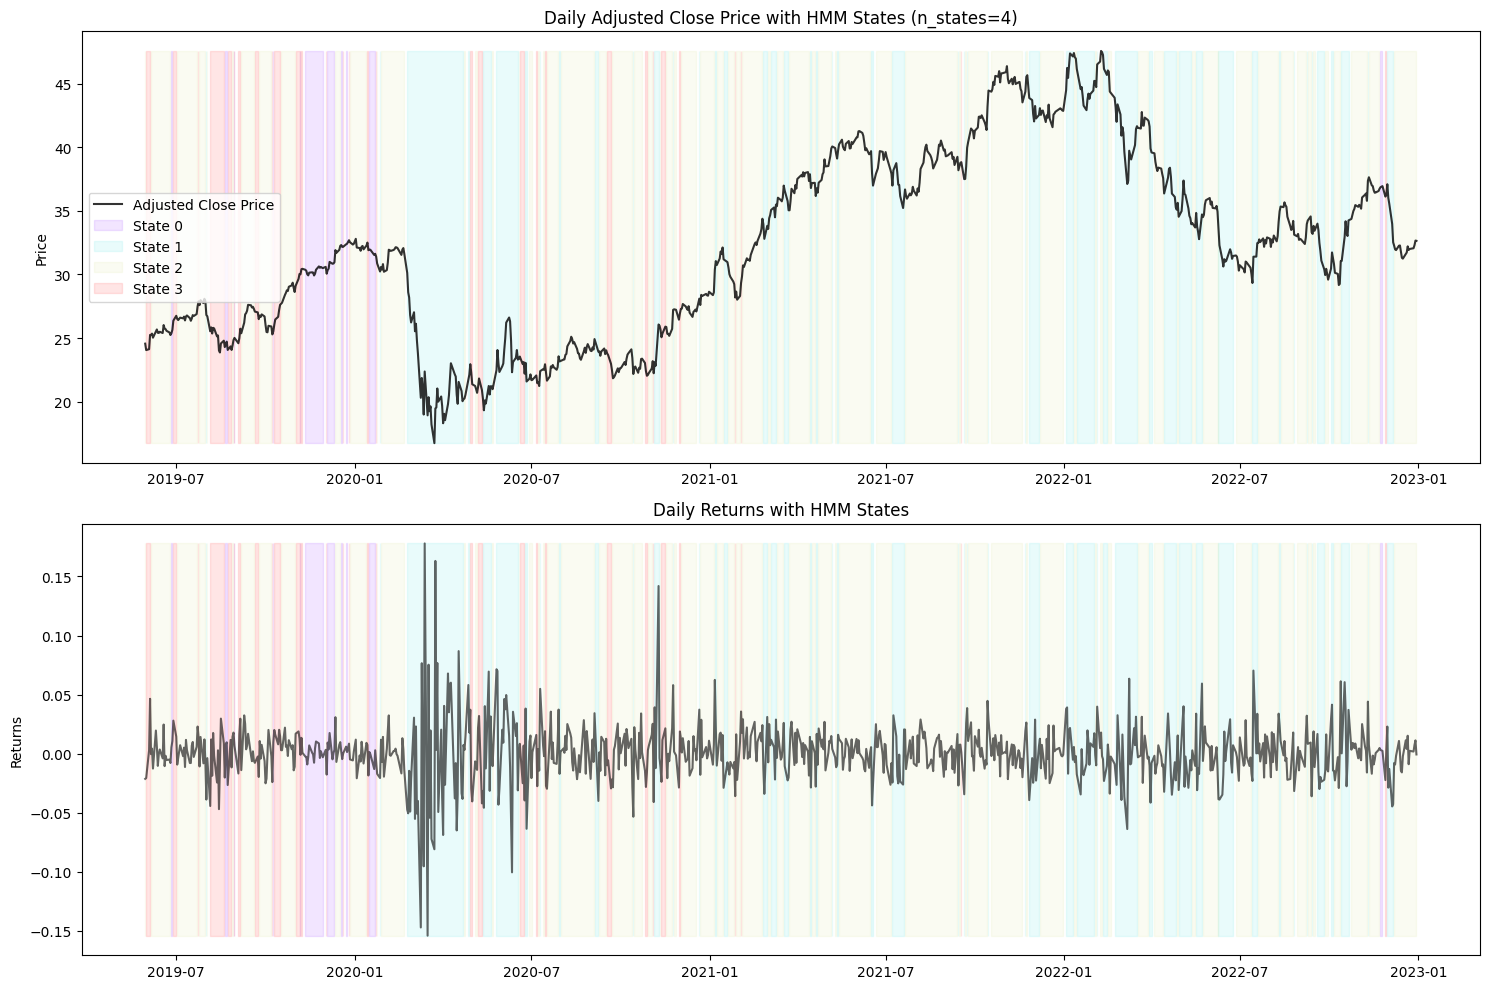

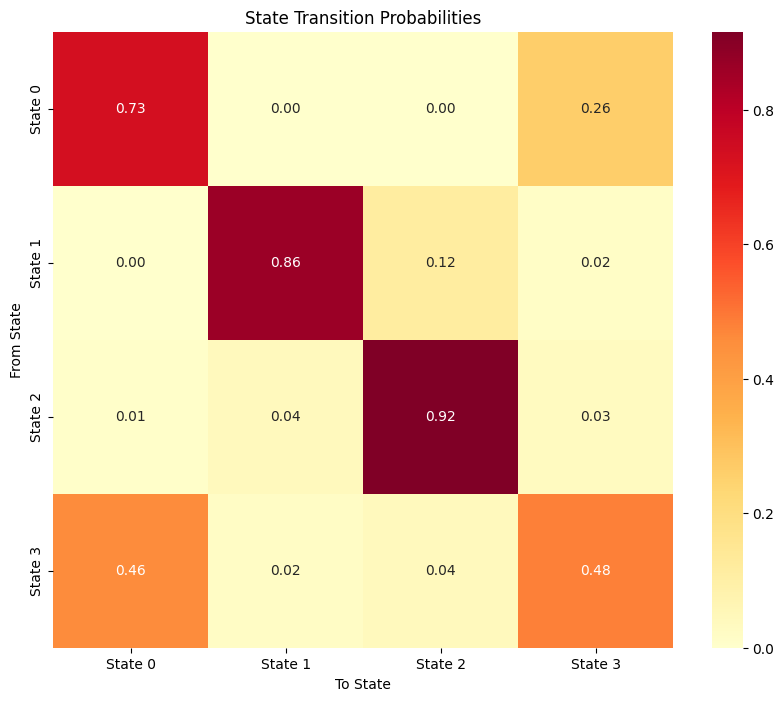


Results for Weekly Prediction (n_states=2):

Training Set Metrics:
Accuracy: 54.40%
Precision: 52.85%
Recall: 85.94%
F1_score: 65.45%

Test Set Metrics:
Accuracy: 57.98%
Precision: 63.46%
Recall: 61.68%
F1_score: 62.56%

Predicted Direction (Test Set): Up
Confidence: 91.76%

State Analysis (Test Set):
State 0 Average Return: 0.53%
State 1 Average Return: -0.07%


<Figure size 1500x1000 with 0 Axes>

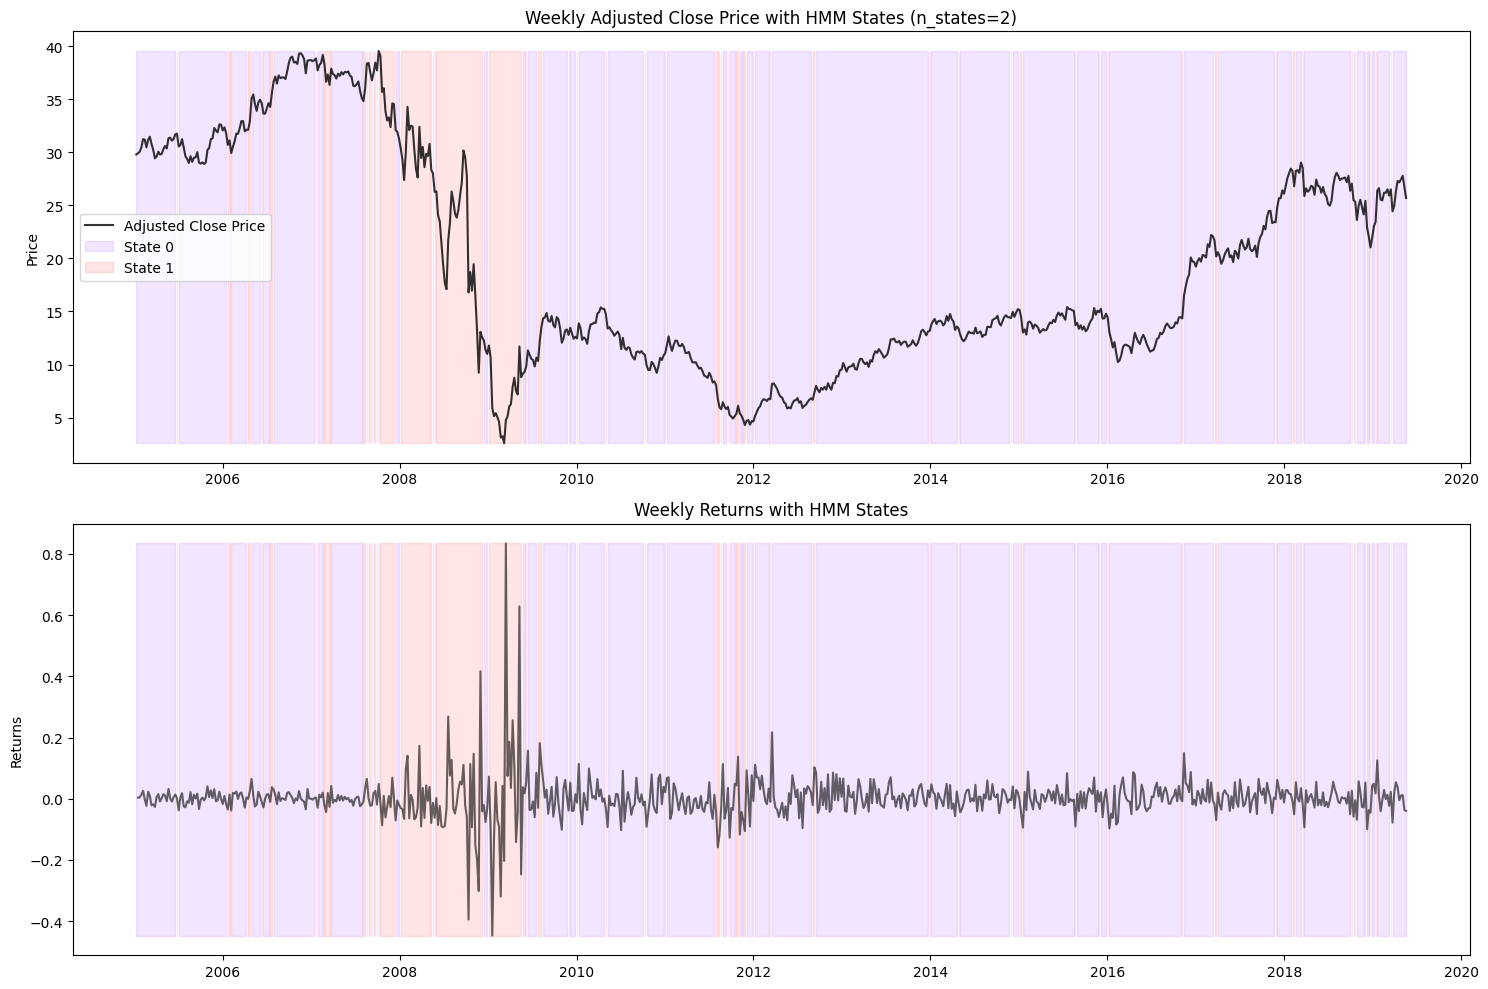

<Figure size 1500x1000 with 0 Axes>

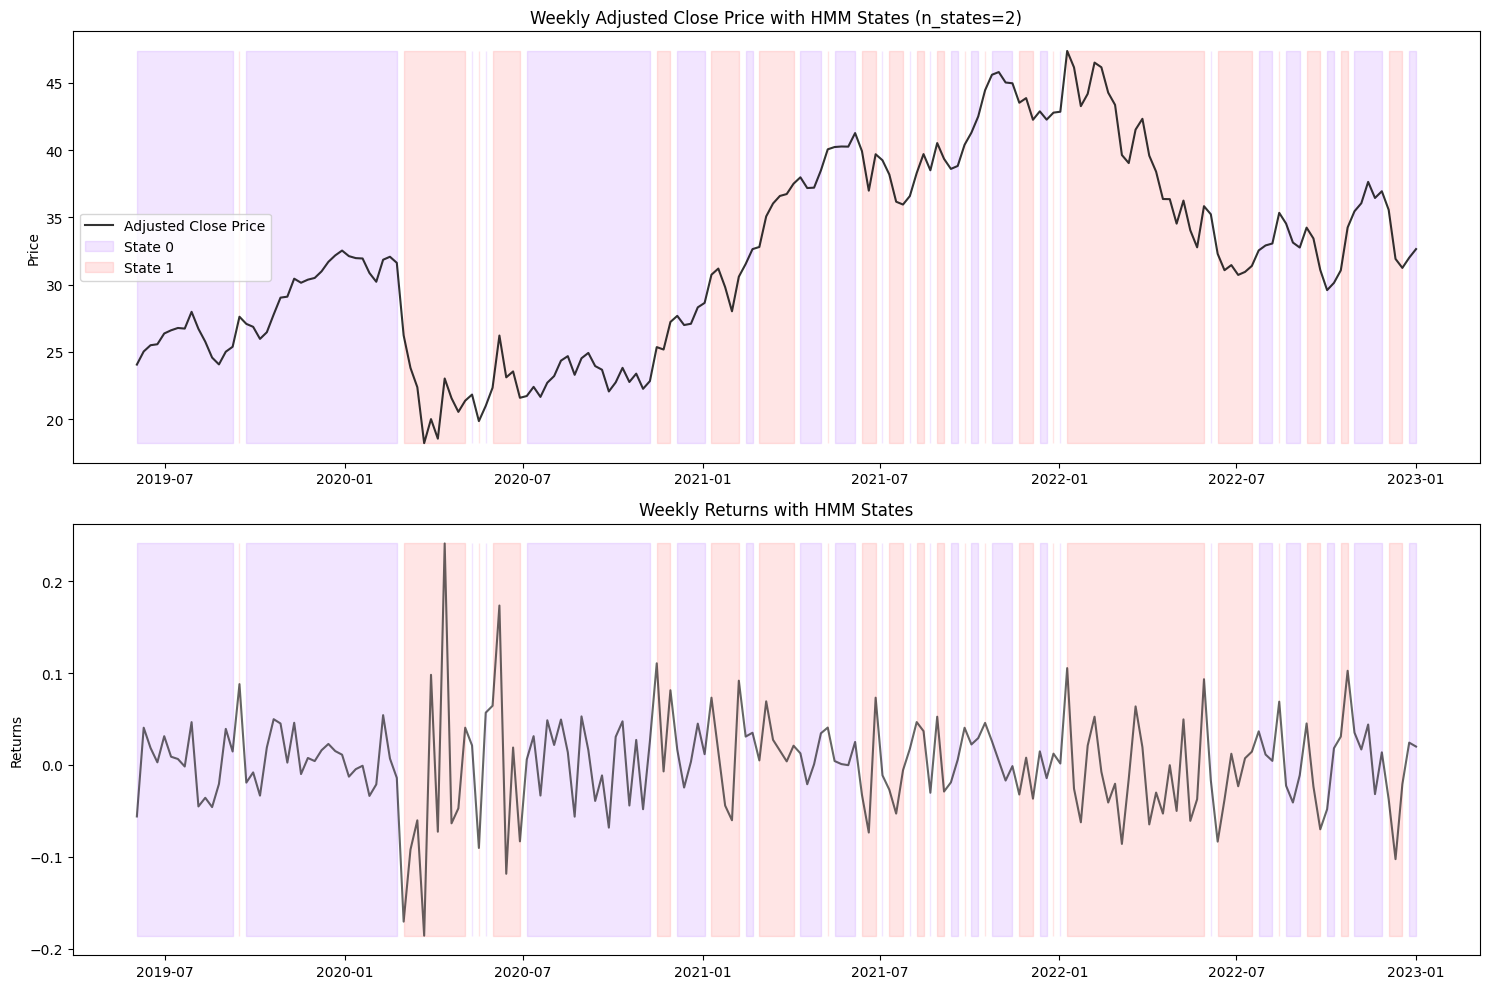

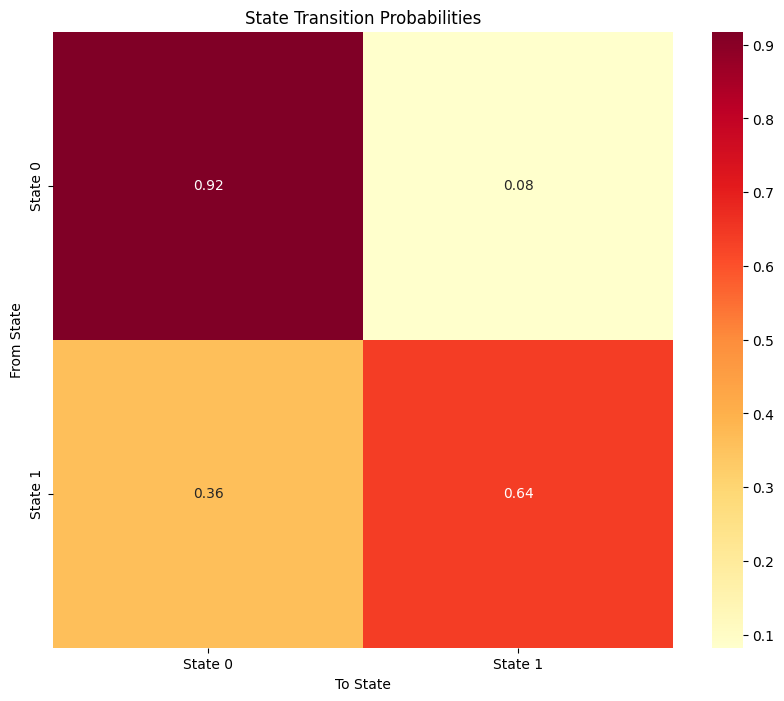


Results for Weekly Prediction (n_states=3):

Training Set Metrics:
Accuracy: 57.33%
Precision: 55.01%
Recall: 83.02%
F1_score: 66.17%

Test Set Metrics:
Accuracy: 59.04%
Precision: 69.23%
Recall: 50.47%
F1_score: 58.38%

Predicted Direction (Test Set): Up
Confidence: 90.81%

State Analysis (Test Set):
State 0 Average Return: 6.10%
State 1 Average Return: -0.66%
State 2 Average Return: 0.57%


<Figure size 1500x1000 with 0 Axes>

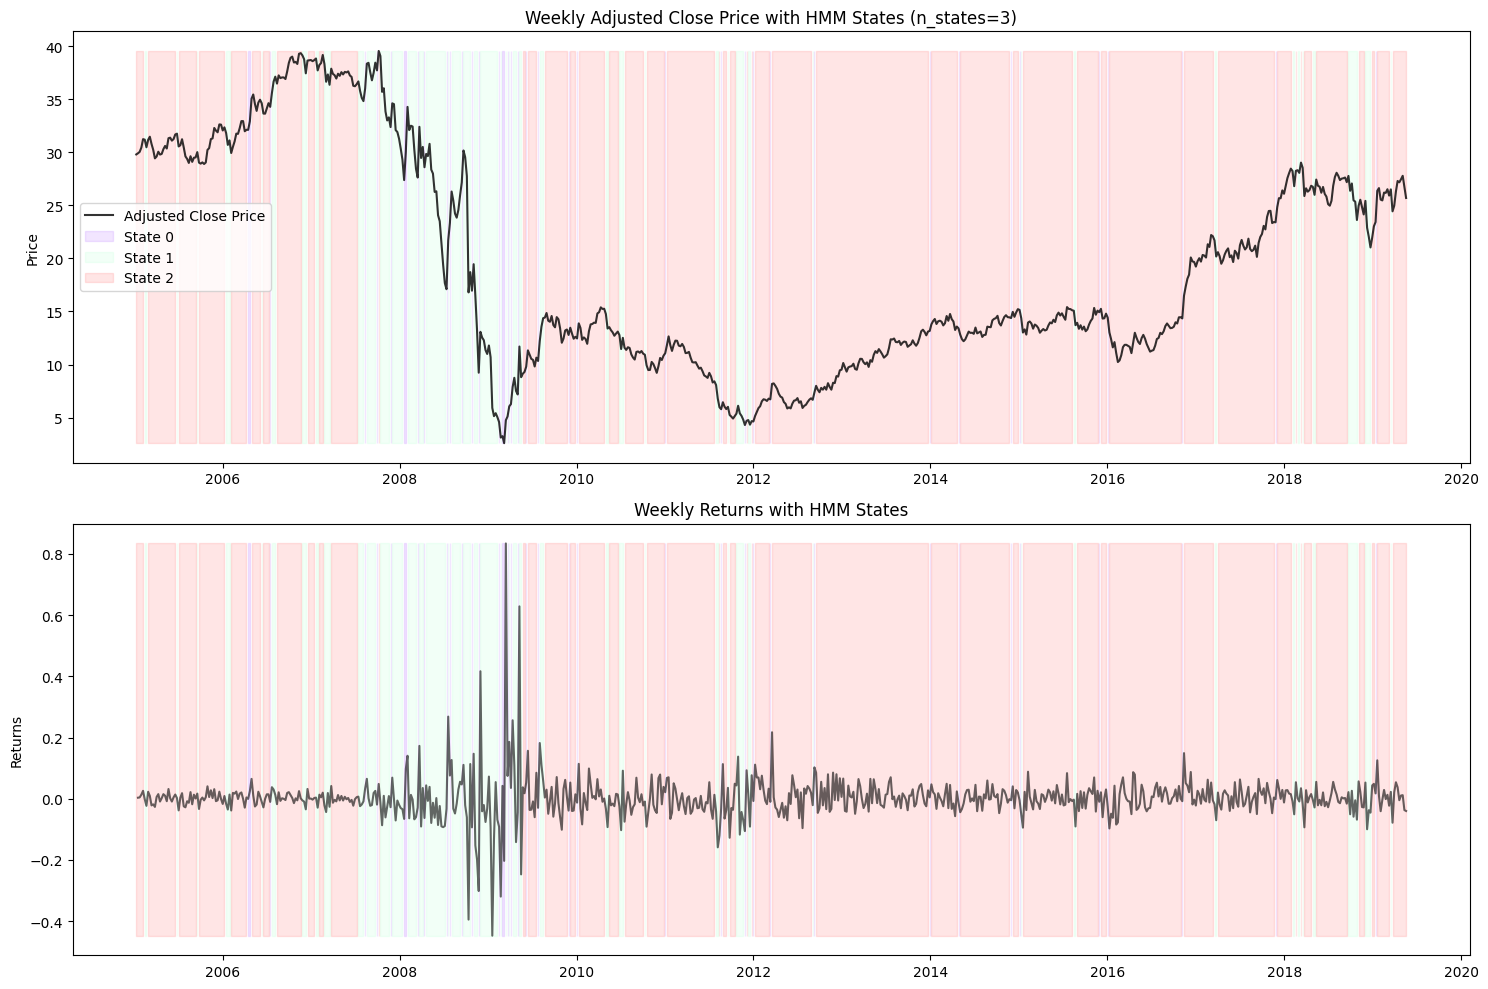

<Figure size 1500x1000 with 0 Axes>

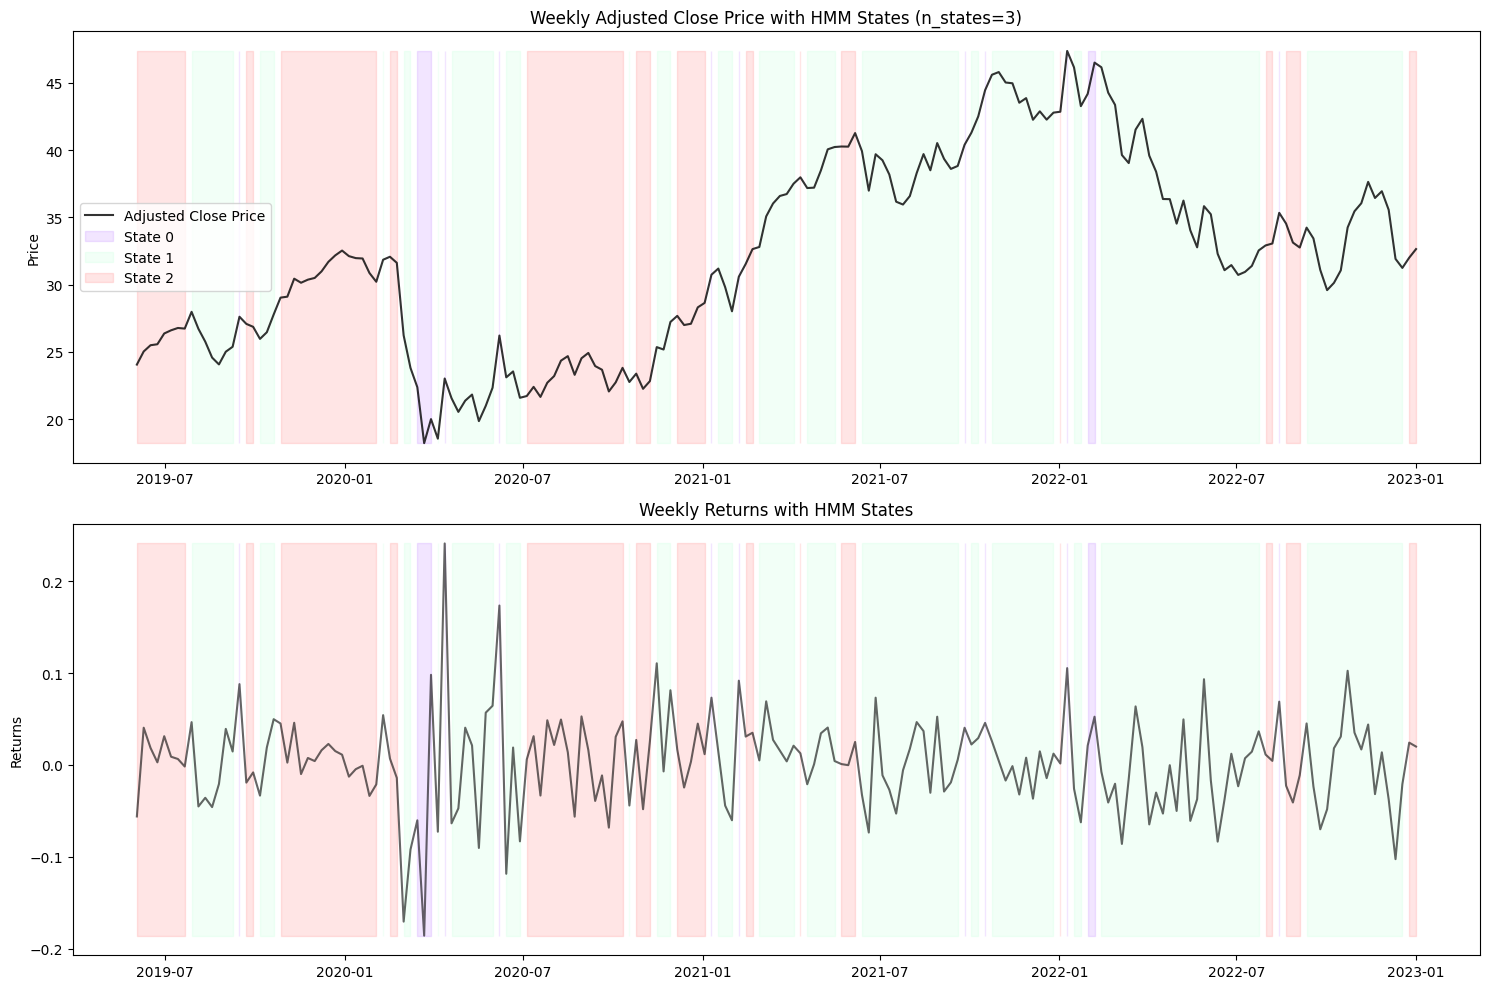

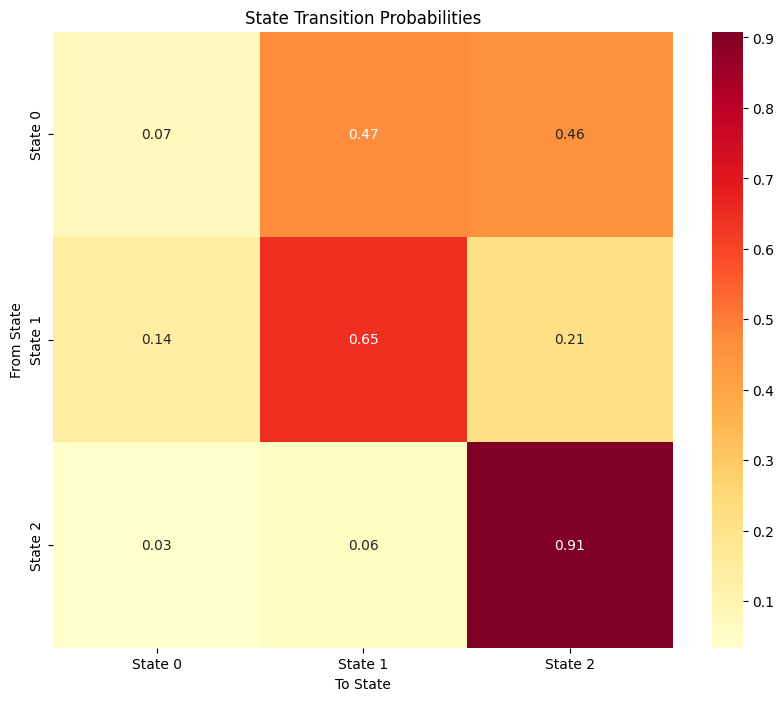


Results for Weekly Prediction (n_states=4):

Training Set Metrics:
Accuracy: 55.20%
Precision: 54.49%
Recall: 66.05%
F1_score: 59.71%

Test Set Metrics:
Accuracy: 60.64%
Precision: 65.14%
Recall: 66.36%
F1_score: 65.74%

Predicted Direction (Test Set): Up
Confidence: 58.88%

State Analysis (Test Set):
State 0 Average Return: 0.20%
State 1 Average Return: 0.90%
State 2 Average Return: 5.14%
State 3 Average Return: -0.83%


<Figure size 1500x1000 with 0 Axes>

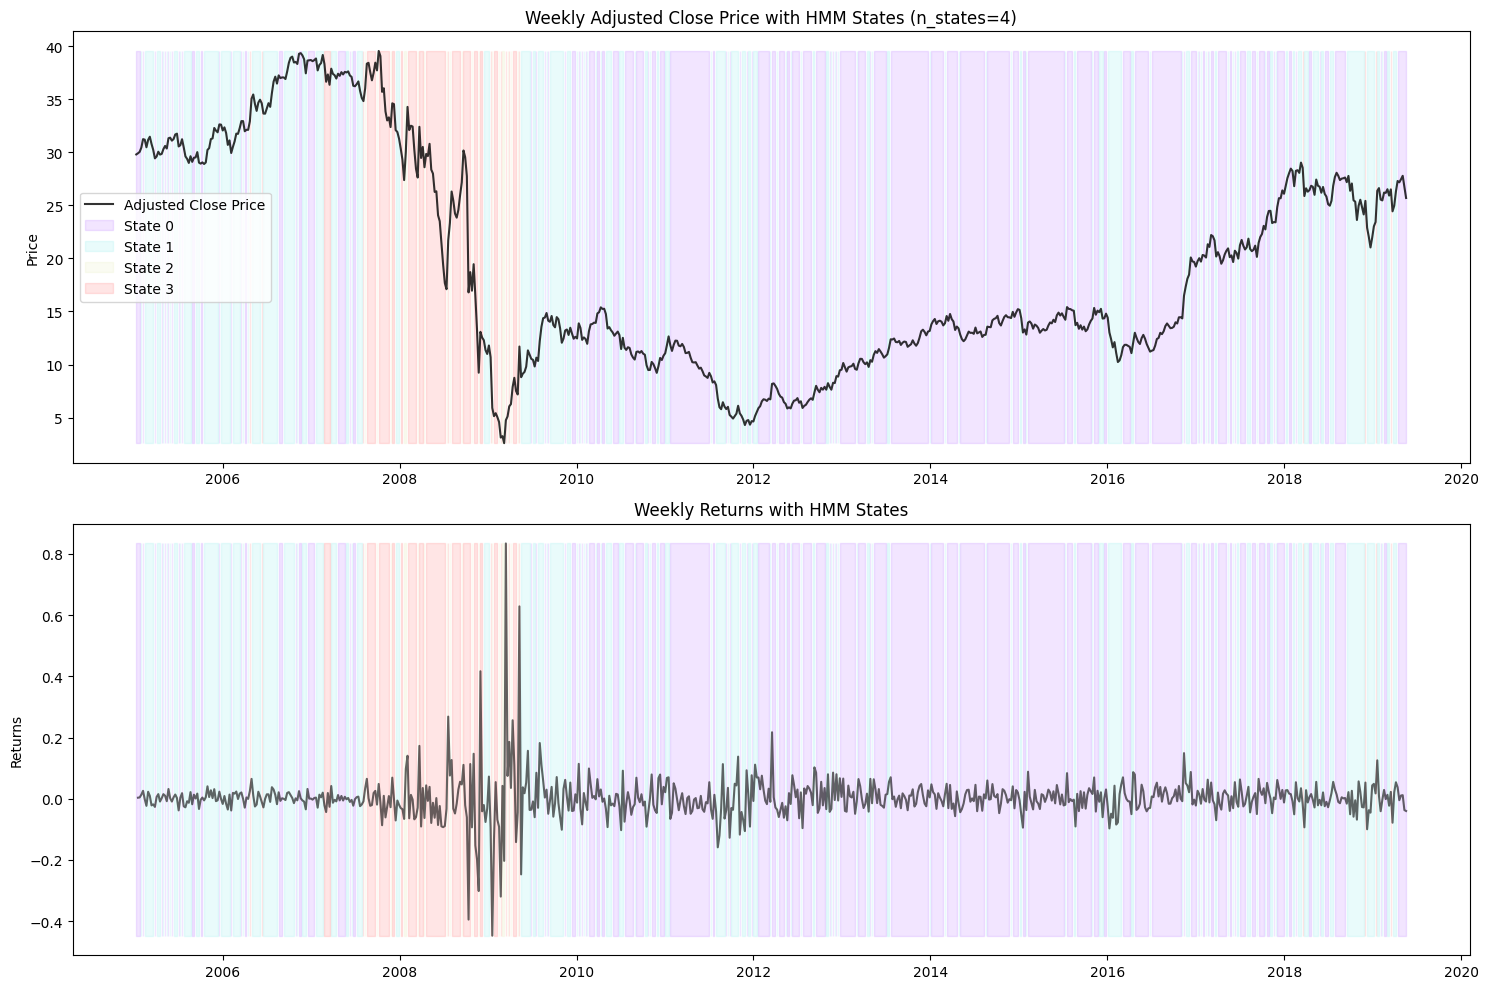

<Figure size 1500x1000 with 0 Axes>

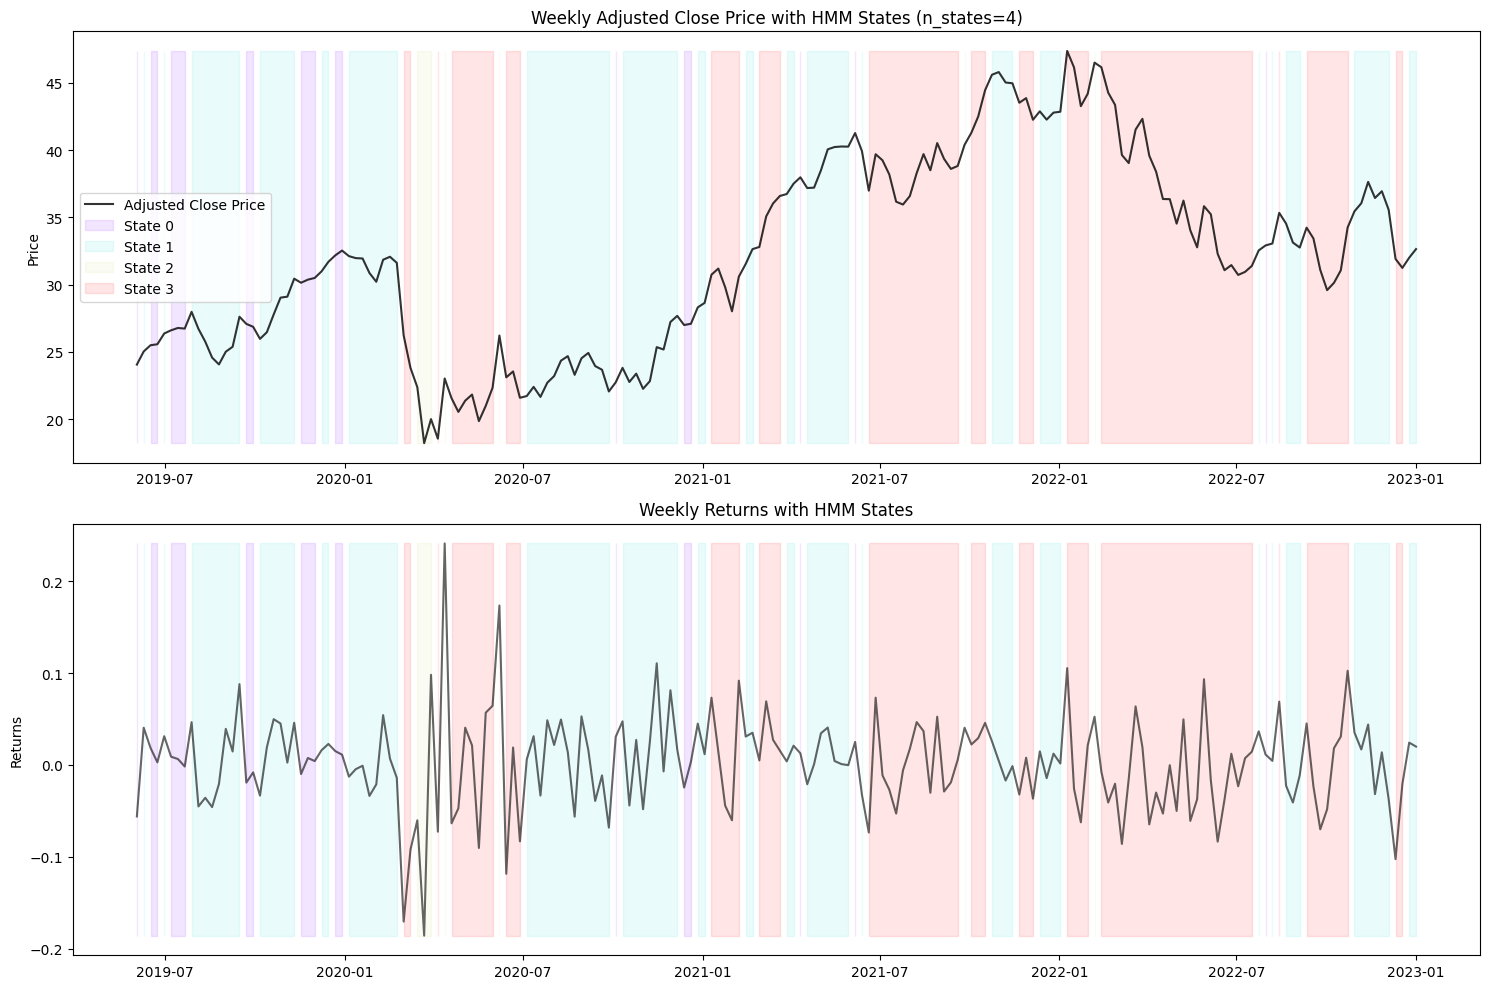

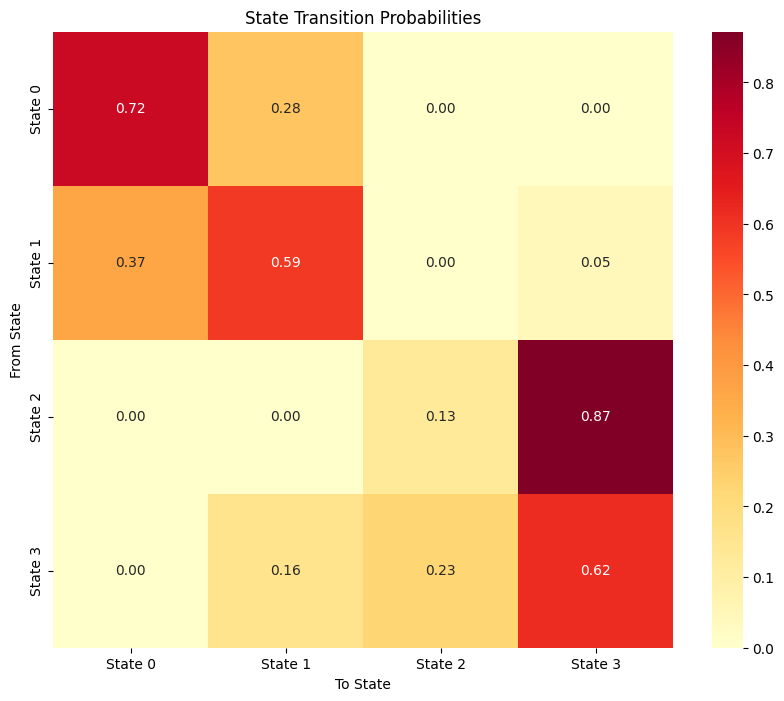


Model Comparison (Test Set Metrics):

Accuracy Comparison:
daily_2_states: 51.21%
daily_3_states: 53.53%
daily_4_states: 53.75%
weekly_2_states: 57.98%
weekly_3_states: 59.04%
weekly_4_states: 60.64%


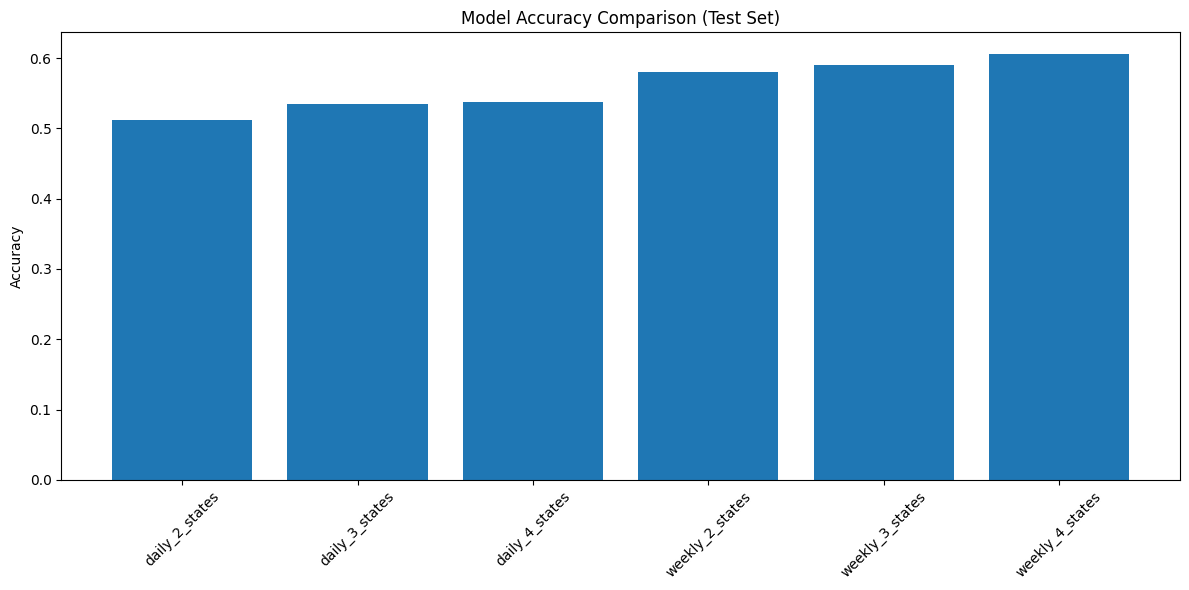

In [ ]:
model_results = {}
data = pd.read_csv('BAC.csv')

for n_states in [2, 3, 4]:
    model_results[f'daily_{n_states}_states'] = evaluate_predictions(data, "daily", n_states)

for n_states in [2, 3, 4]:
    model_results[f'weekly_{n_states}_states'] = evaluate_predictions(data, "weekly", n_states)

print("\nModel Comparison (Test Set Metrics):")
print("\nAccuracy Comparison:")
for model_name, results in model_results.items():
    print(f"{model_name}: {results['test_metrics']['accuracy']:.2%}")

plt.figure(figsize=(12, 6))
accuracies = [results['test_metrics']['accuracy'] for results in model_results.values()]
model_names = list(model_results.keys())

plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison (Test Set)')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


Results for Daily Prediction (n_states=2):

Training Set Metrics:
Accuracy: 51.47%
Precision: 50.72%
Recall: 81.01%
F1_score: 62.38%

Test Set Metrics:
Accuracy: 51.22%
Precision: 51.22%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 84.95%

State Analysis (Test Set):
State 0 Average Return: 0.01%
State 1 Average Return: 0.13%


<Figure size 1500x1000 with 0 Axes>

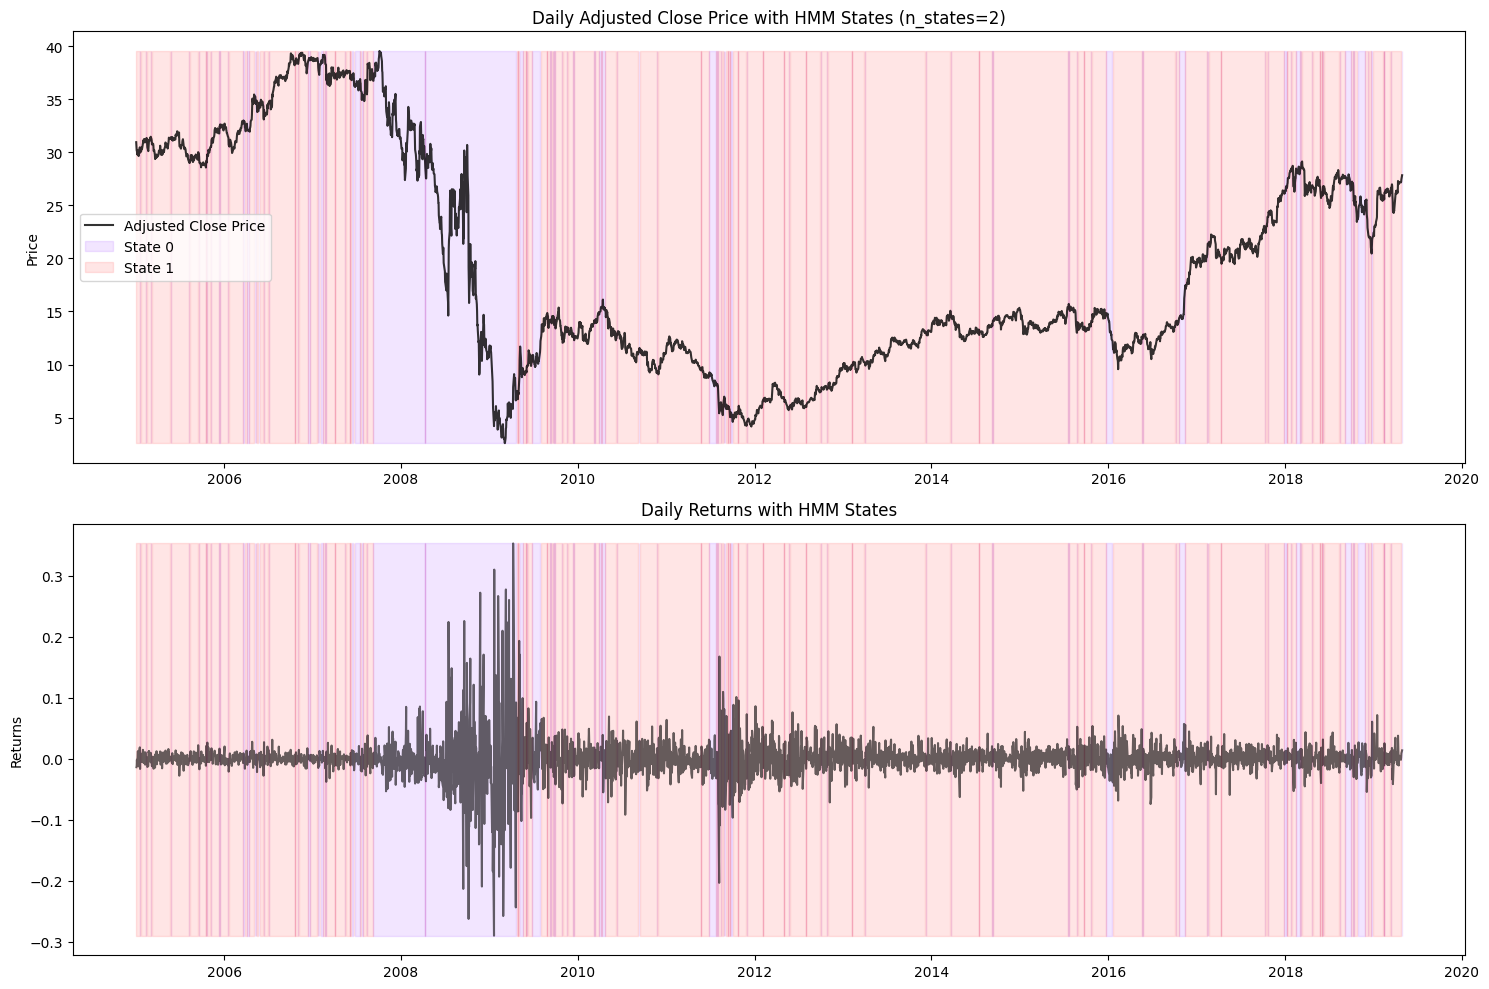

<Figure size 1500x1000 with 0 Axes>

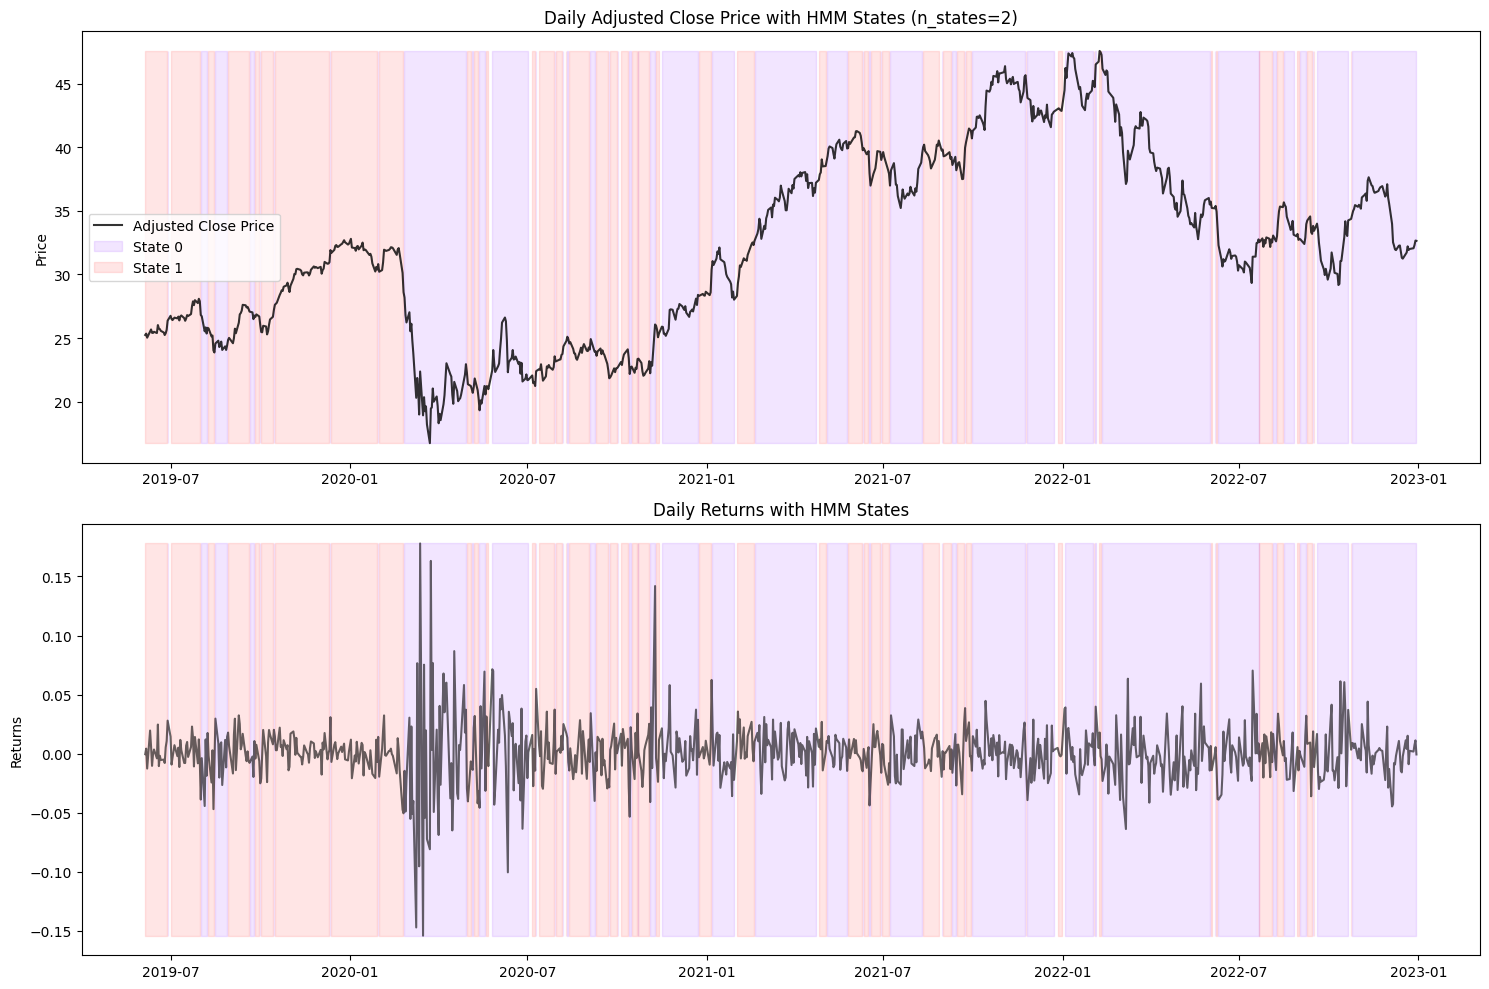

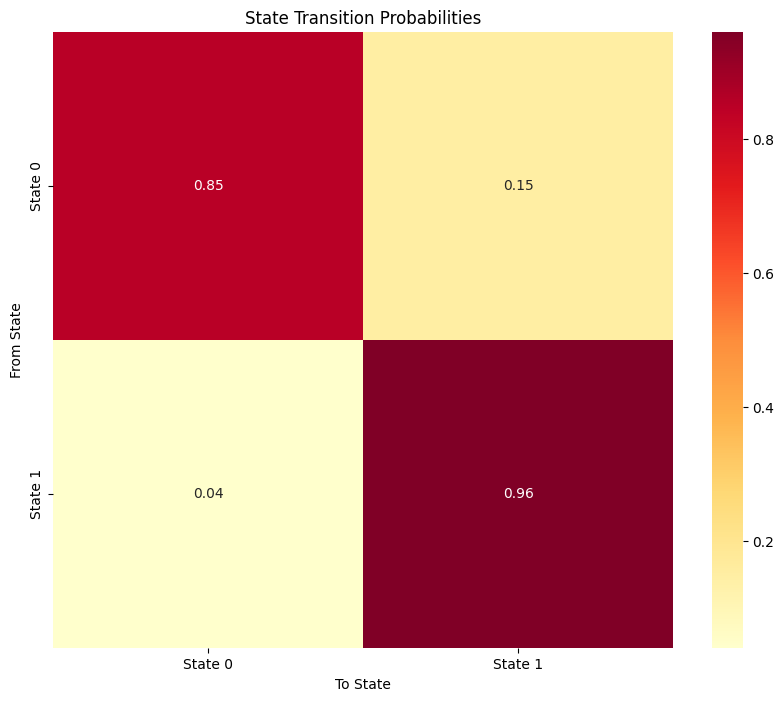


Results for Daily Prediction (n_states=3):

Training Set Metrics:
Accuracy: 51.36%
Precision: 50.60%
Recall: 86.65%
F1_score: 63.89%

Test Set Metrics:
Accuracy: 55.65%
Precision: 55.24%
Recall: 70.78%
F1_score: 62.05%

Predicted Direction (Test Set): Up
Confidence: 97.26%

State Analysis (Test Set):
State 0 Average Return: nan%
State 1 Average Return: -0.12%
State 2 Average Return: 0.15%


<Figure size 1500x1000 with 0 Axes>

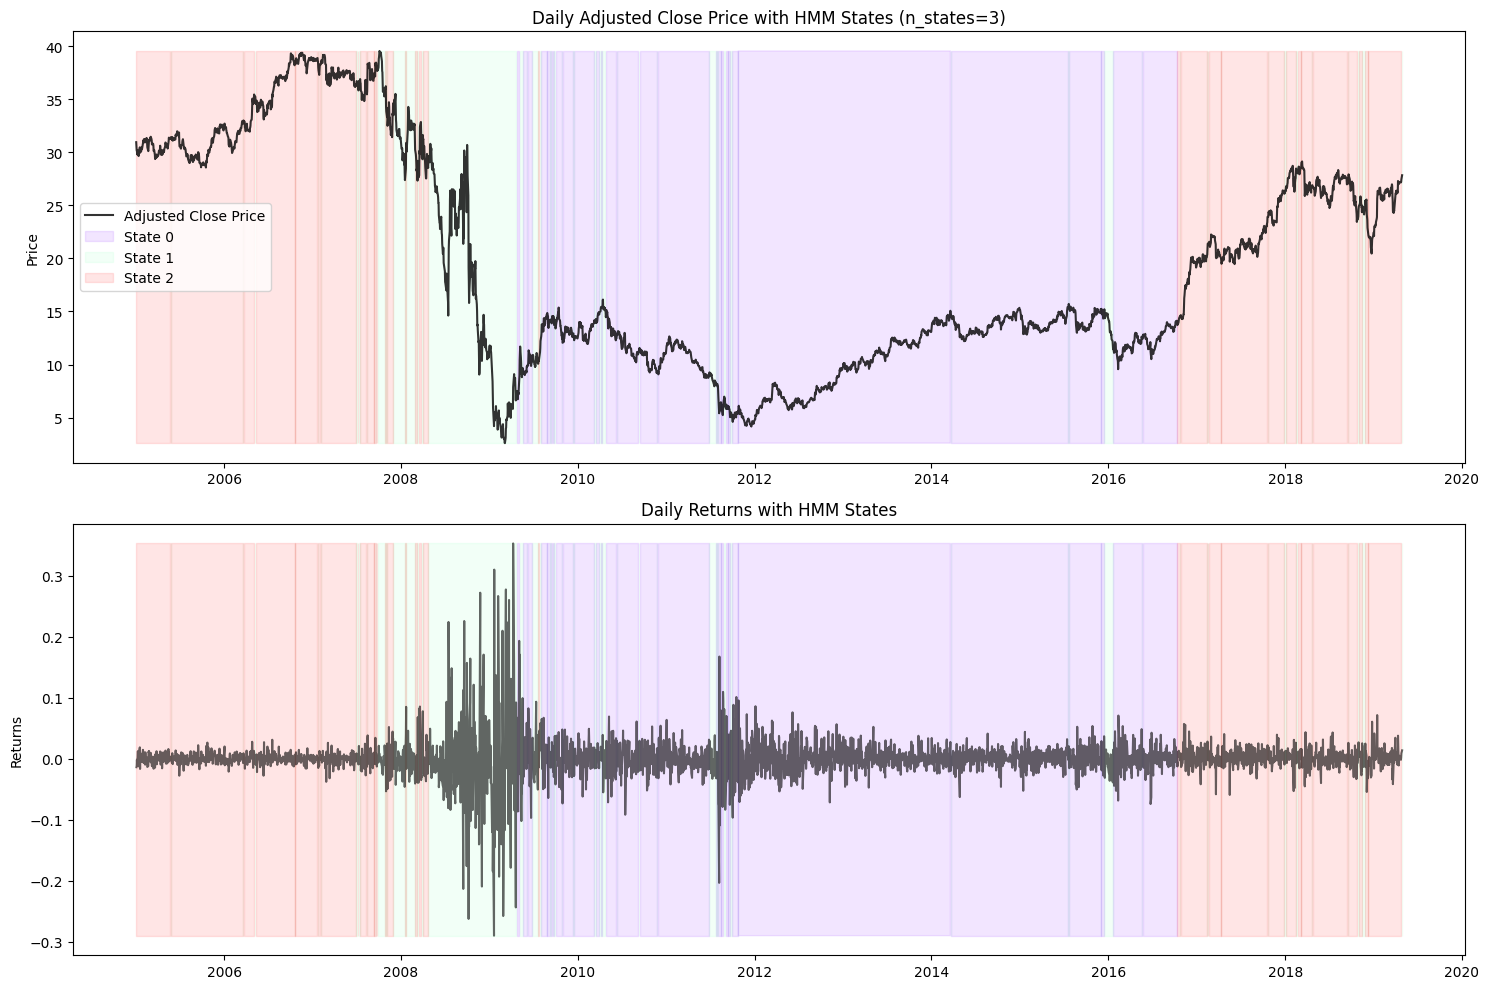

<Figure size 1500x1000 with 0 Axes>

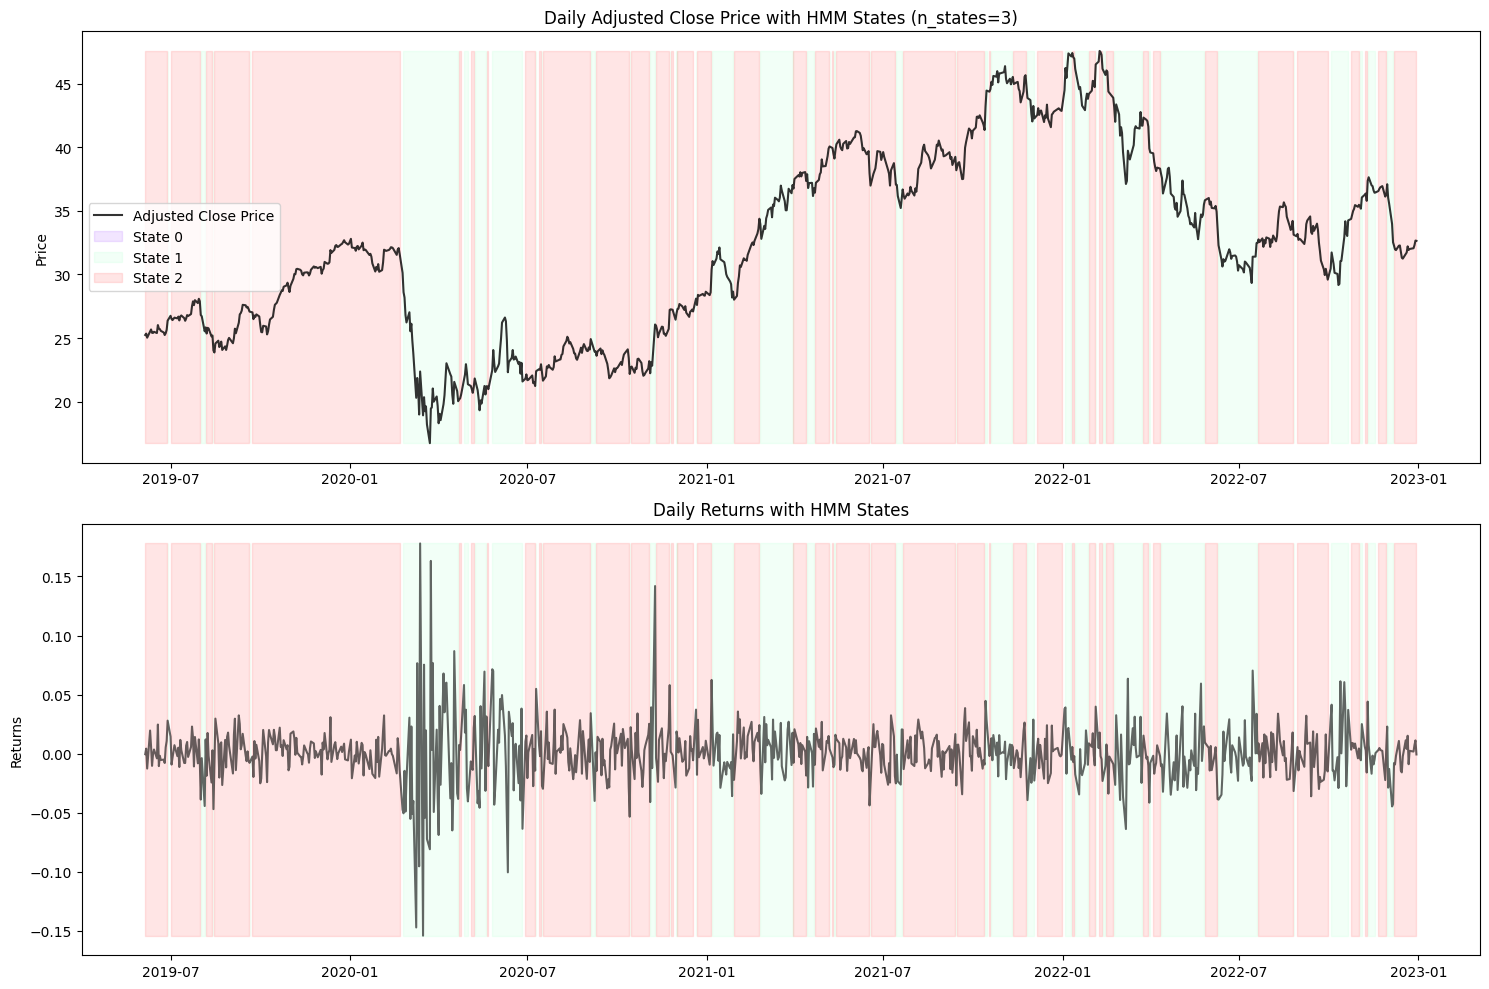

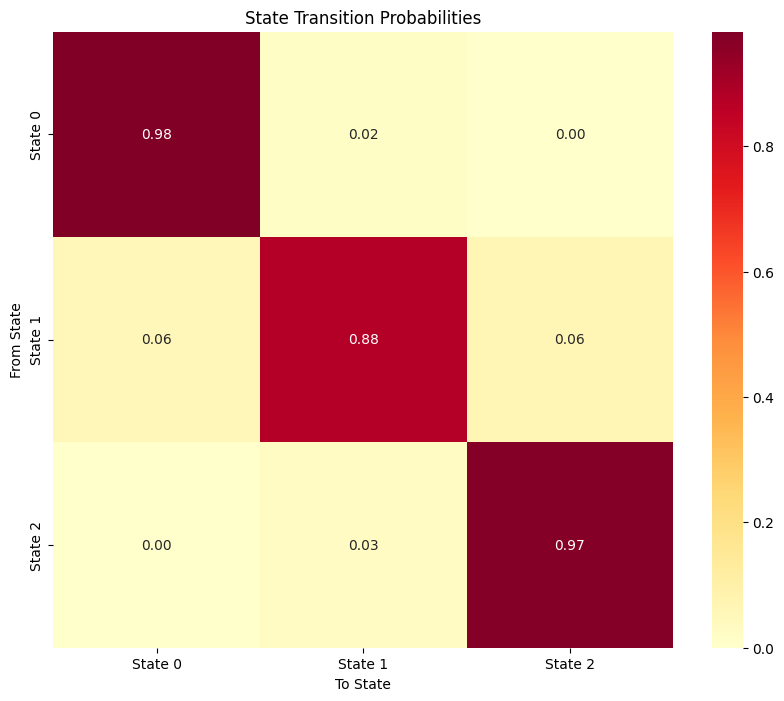


Results for Daily Prediction (n_states=4):

Training Set Metrics:
Accuracy: 50.69%
Precision: 50.20%
Recall: 93.07%
F1_score: 65.22%

Test Set Metrics:
Accuracy: 51.33%
Precision: 51.40%
Recall: 91.34%
F1_score: 65.78%

Predicted Direction (Test Set): Up
Confidence: 80.81%

State Analysis (Test Set):
State 0 Average Return: 0.01%
State 1 Average Return: nan%
State 2 Average Return: -0.08%
State 3 Average Return: 0.15%


<Figure size 1500x1000 with 0 Axes>

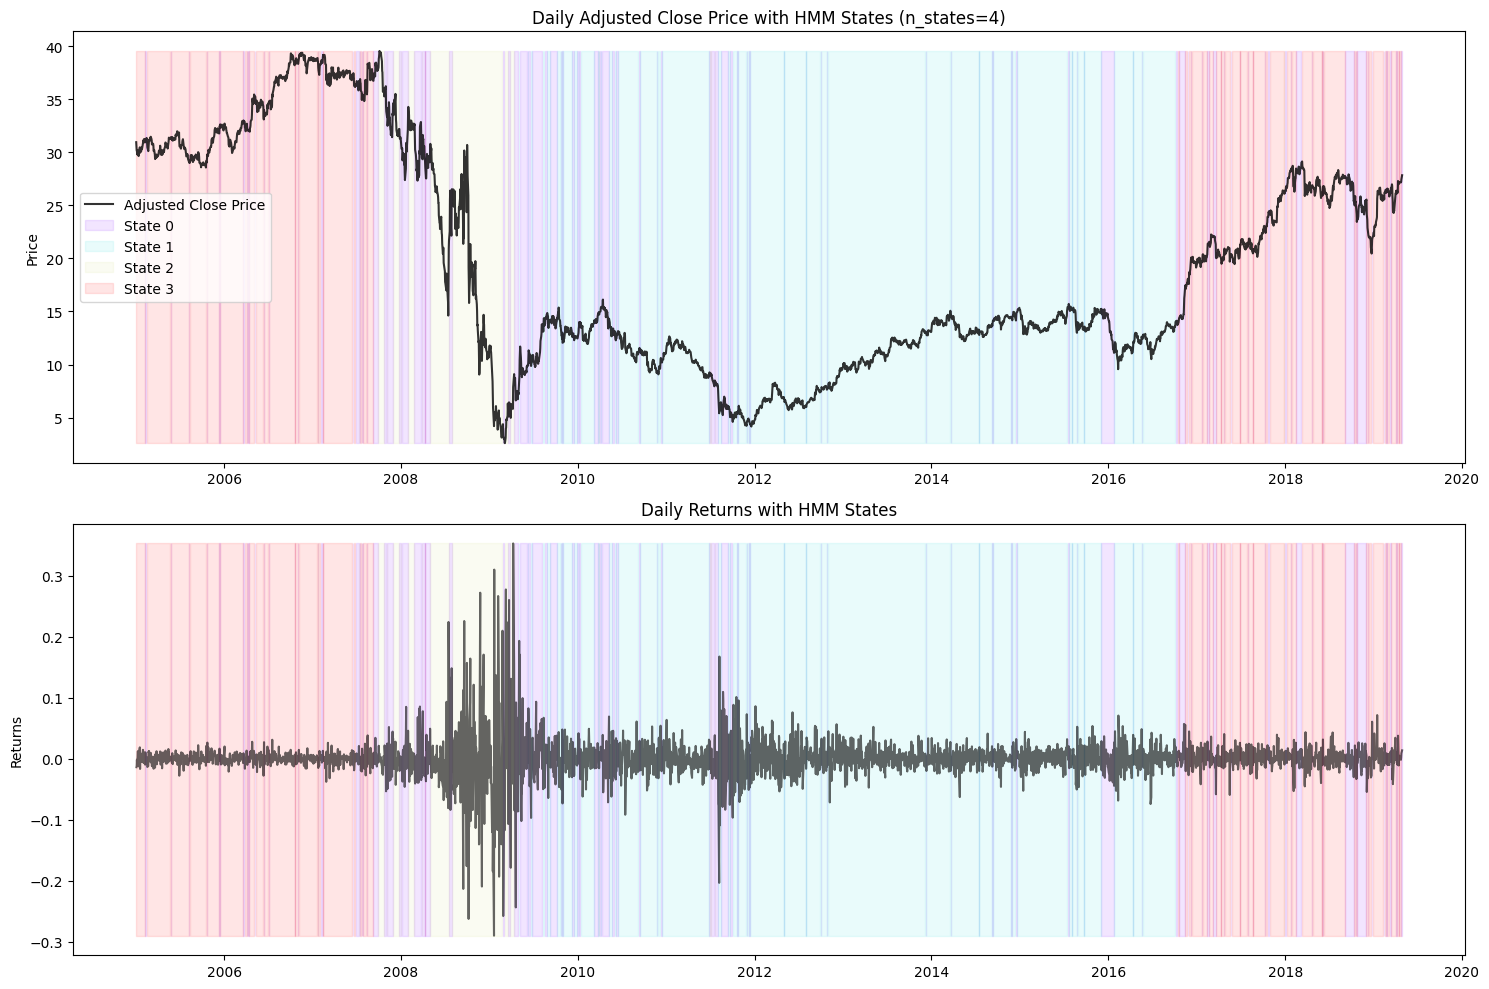

<Figure size 1500x1000 with 0 Axes>

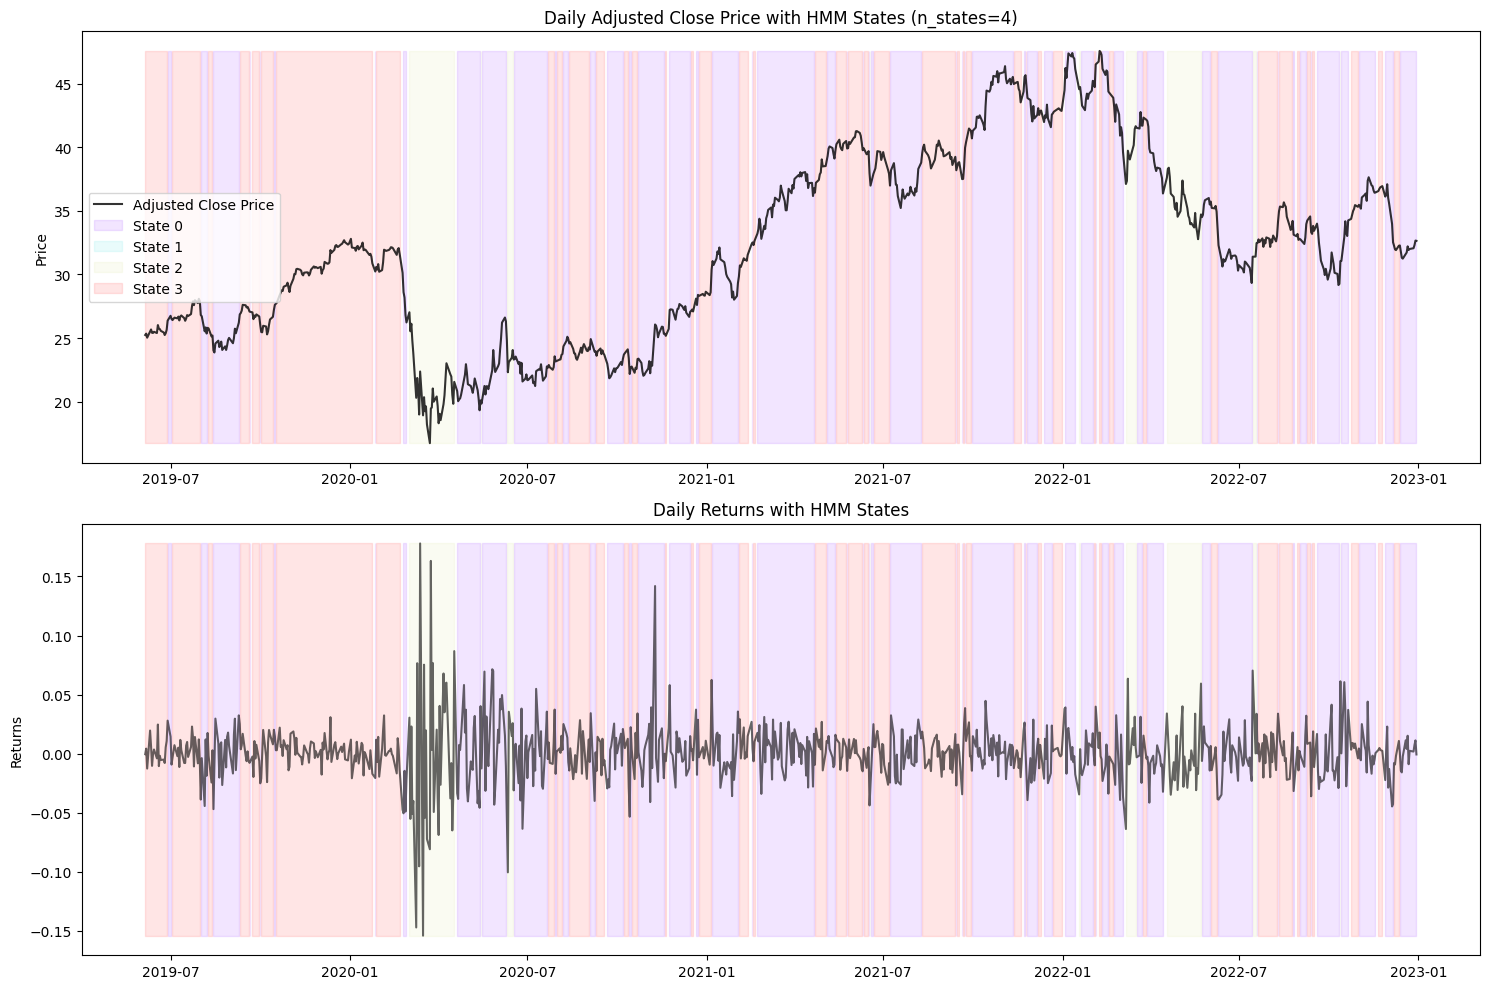

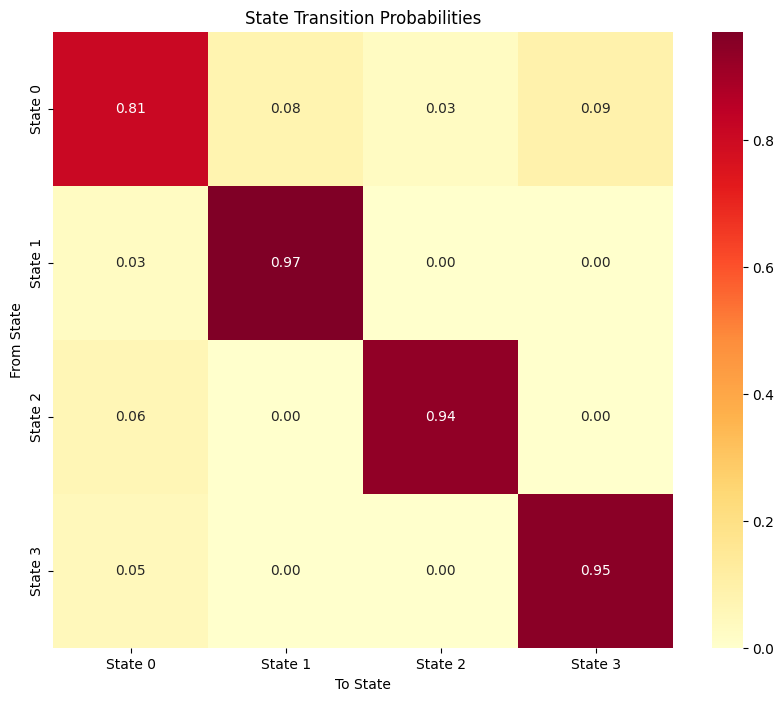


Results for Weekly Prediction (n_states=2):

Training Set Metrics:
Accuracy: 53.49%
Precision: 52.12%
Recall: 87.16%
F1_score: 65.24%

Test Set Metrics:
Accuracy: 56.28%
Precision: 56.28%
Recall: 100.00%
F1_score: 72.03%

Predicted Direction (Test Set): Up
Confidence: 97.25%

State Analysis (Test Set):
State 0 Average Return: 0.04%
State 1 Average Return: 0.72%


<Figure size 1500x1000 with 0 Axes>

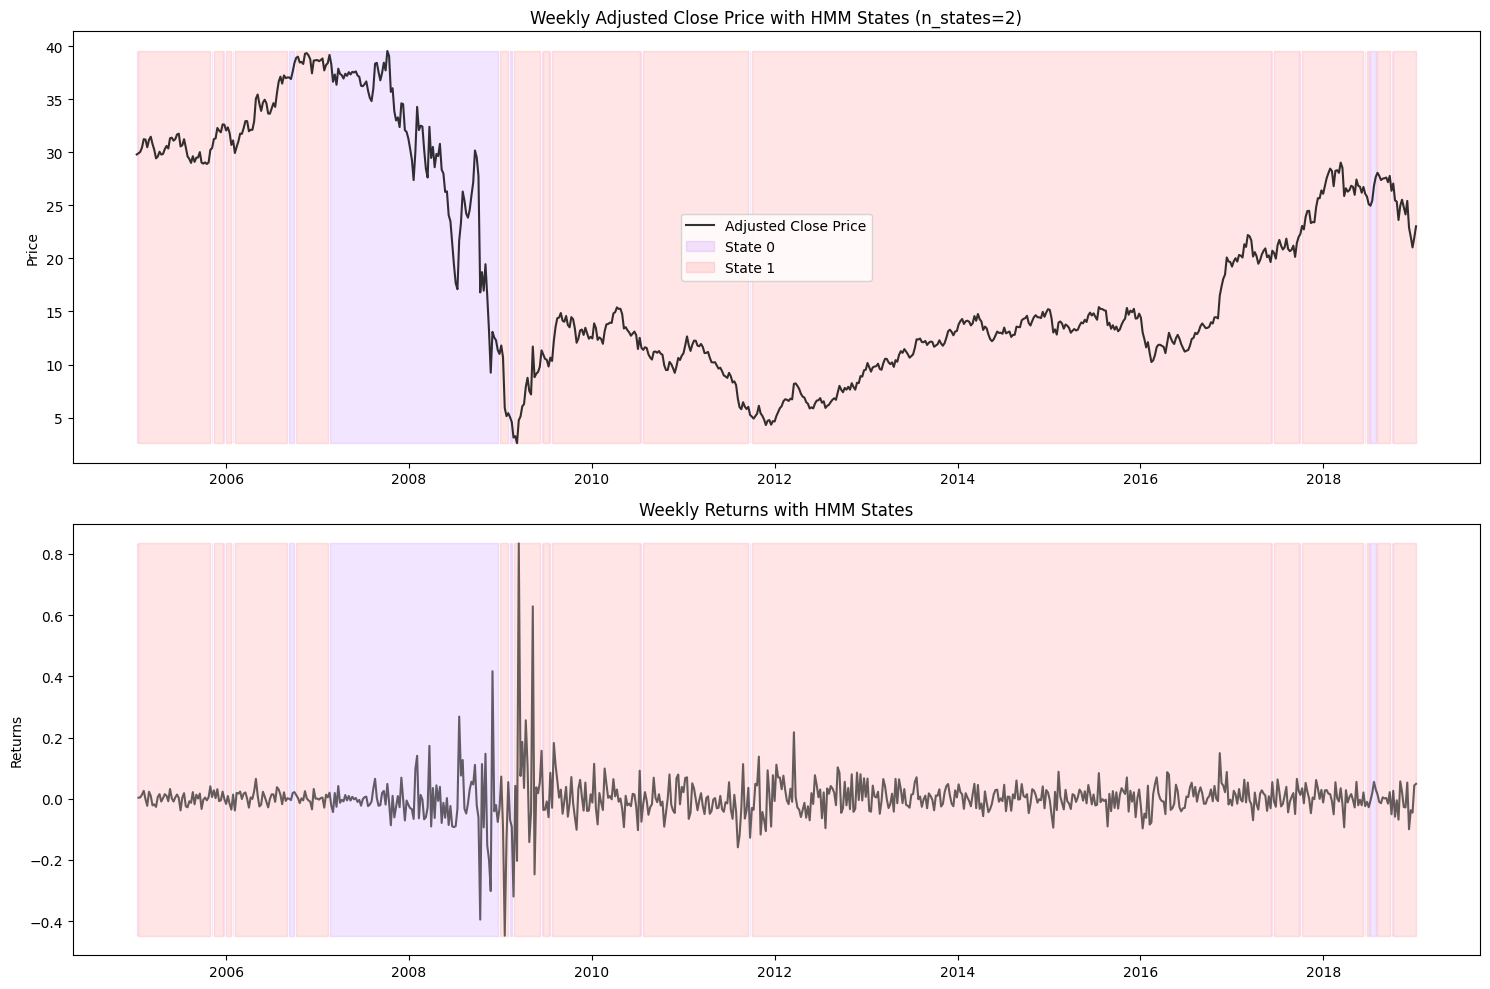

<Figure size 1500x1000 with 0 Axes>

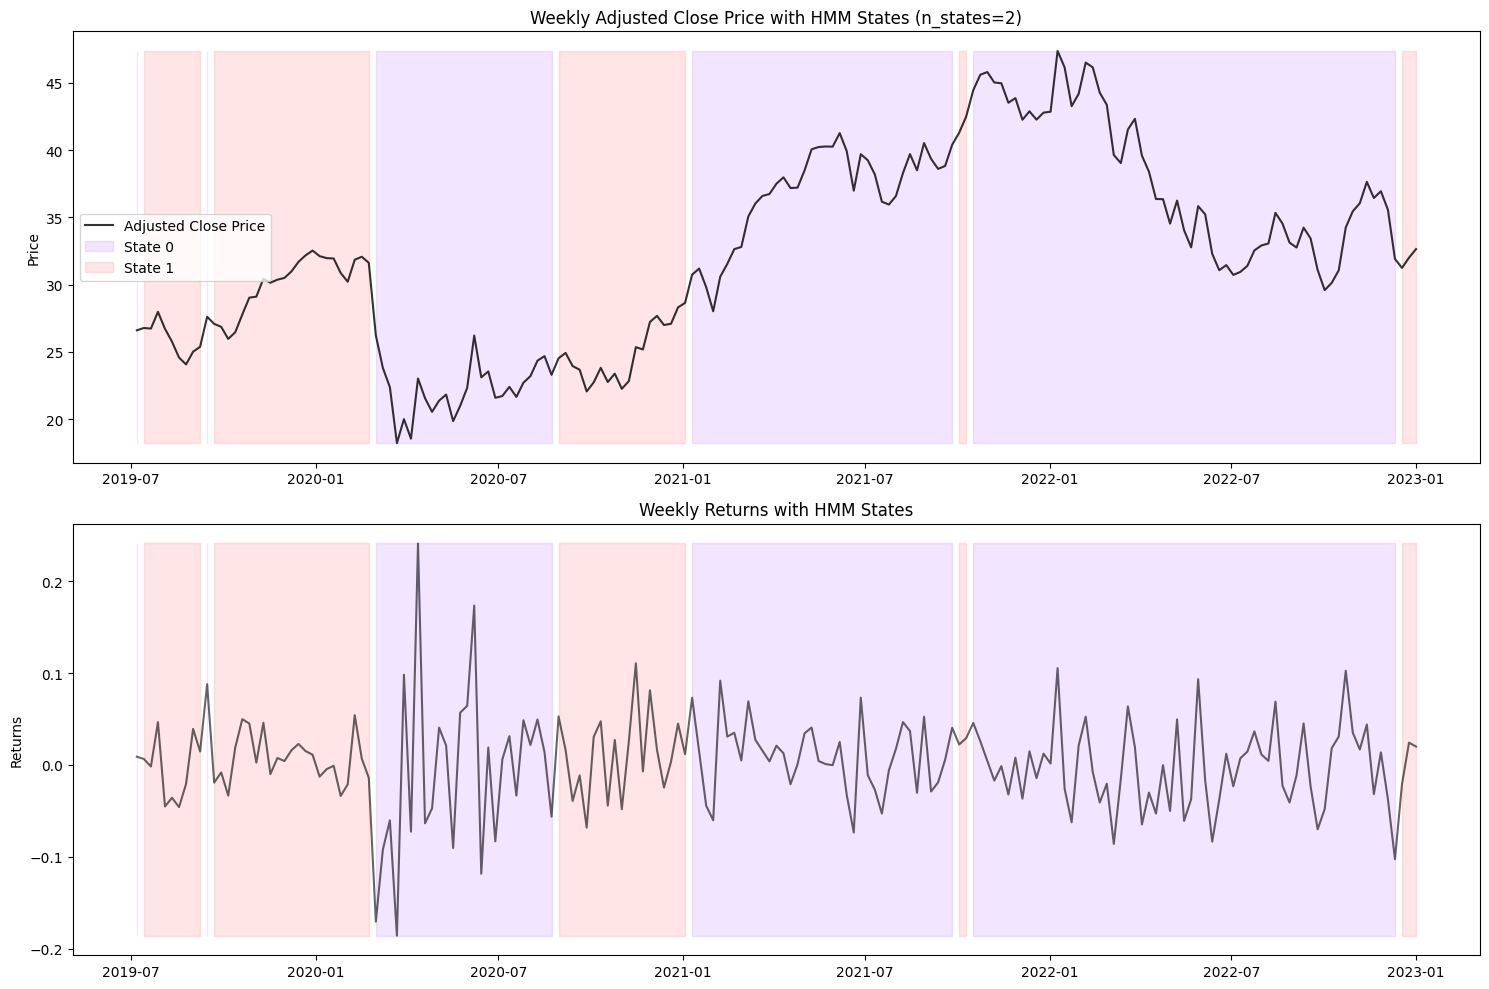

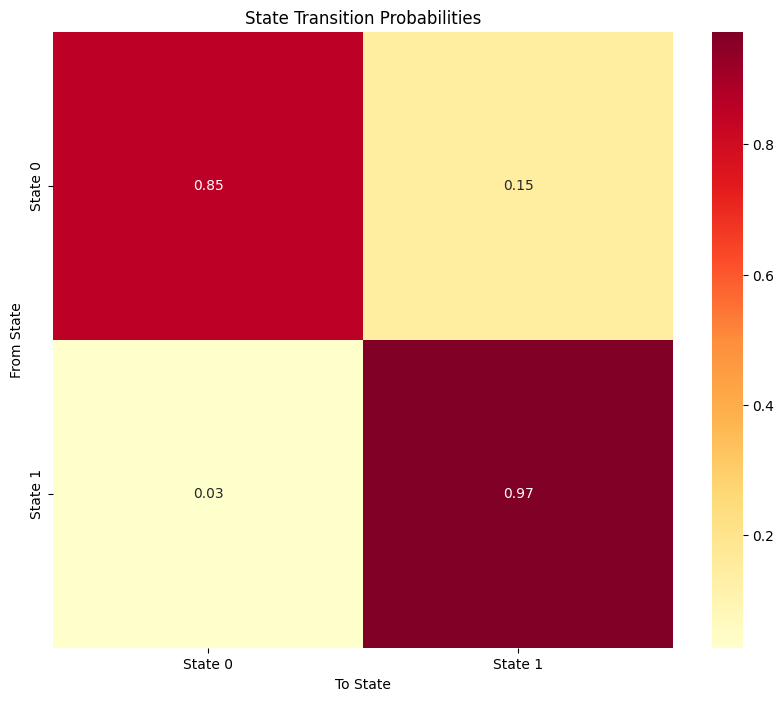


Results for Weekly Prediction (n_states=3):

Training Set Metrics:
Accuracy: 52.80%
Precision: 51.64%
Recall: 90.16%
F1_score: 65.67%

Test Set Metrics:
Accuracy: 59.02%
Precision: 64.00%
Recall: 62.14%
F1_score: 63.05%

Predicted Direction (Test Set): Up
Confidence: 95.81%

State Analysis (Test Set):
State 0 Average Return: nan%
State 1 Average Return: 0.87%
State 2 Average Return: -0.49%


<Figure size 1500x1000 with 0 Axes>

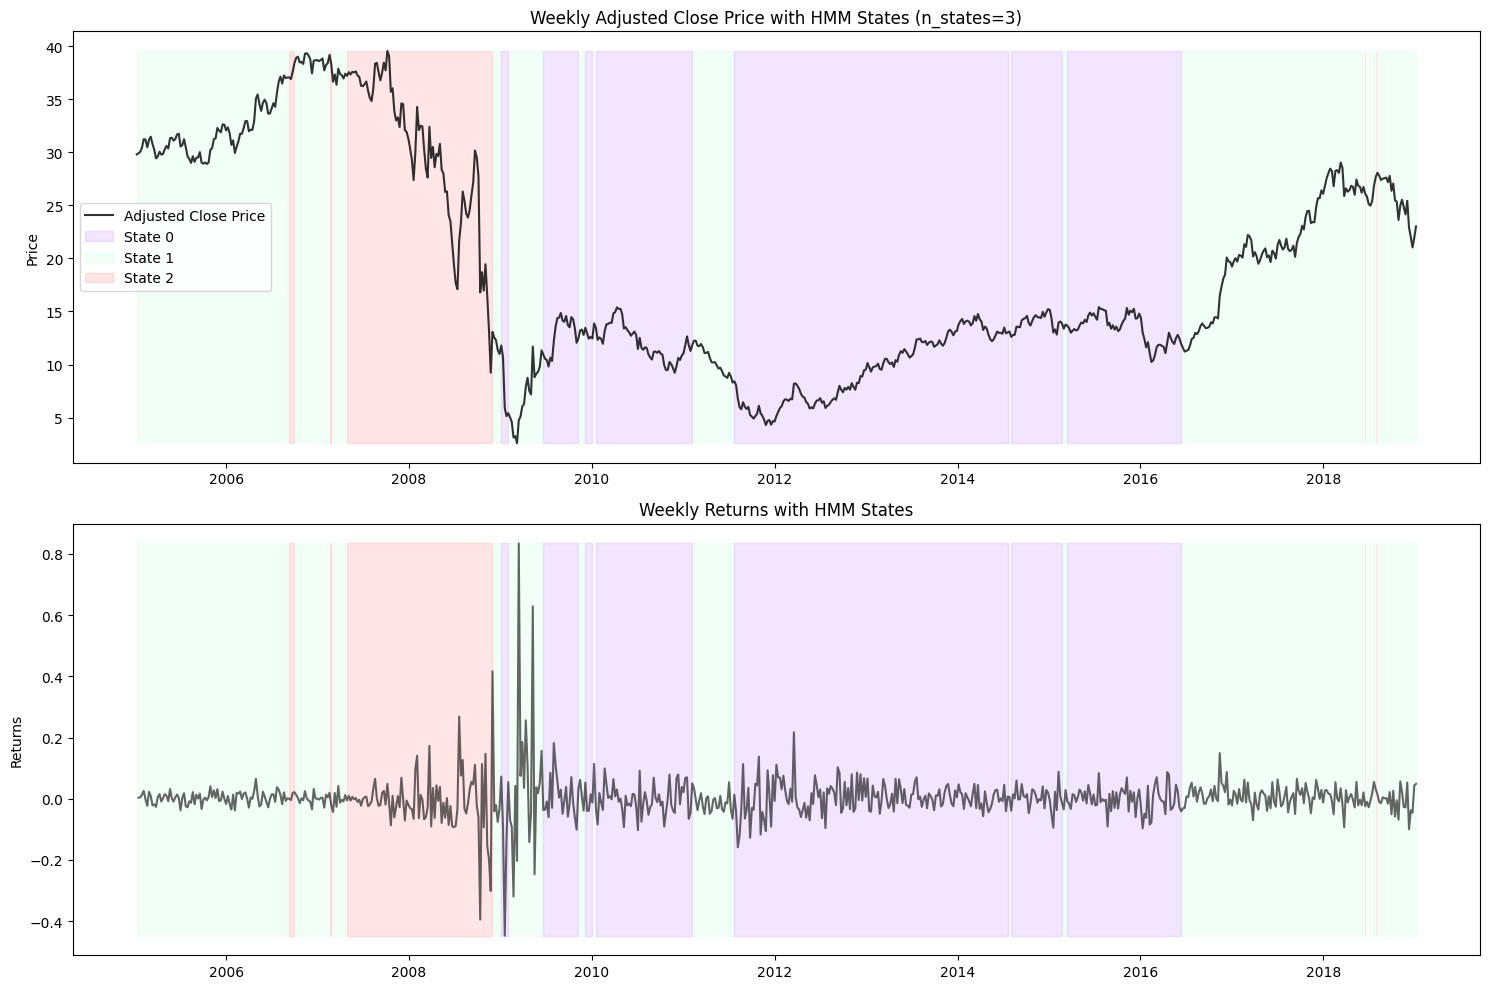

<Figure size 1500x1000 with 0 Axes>

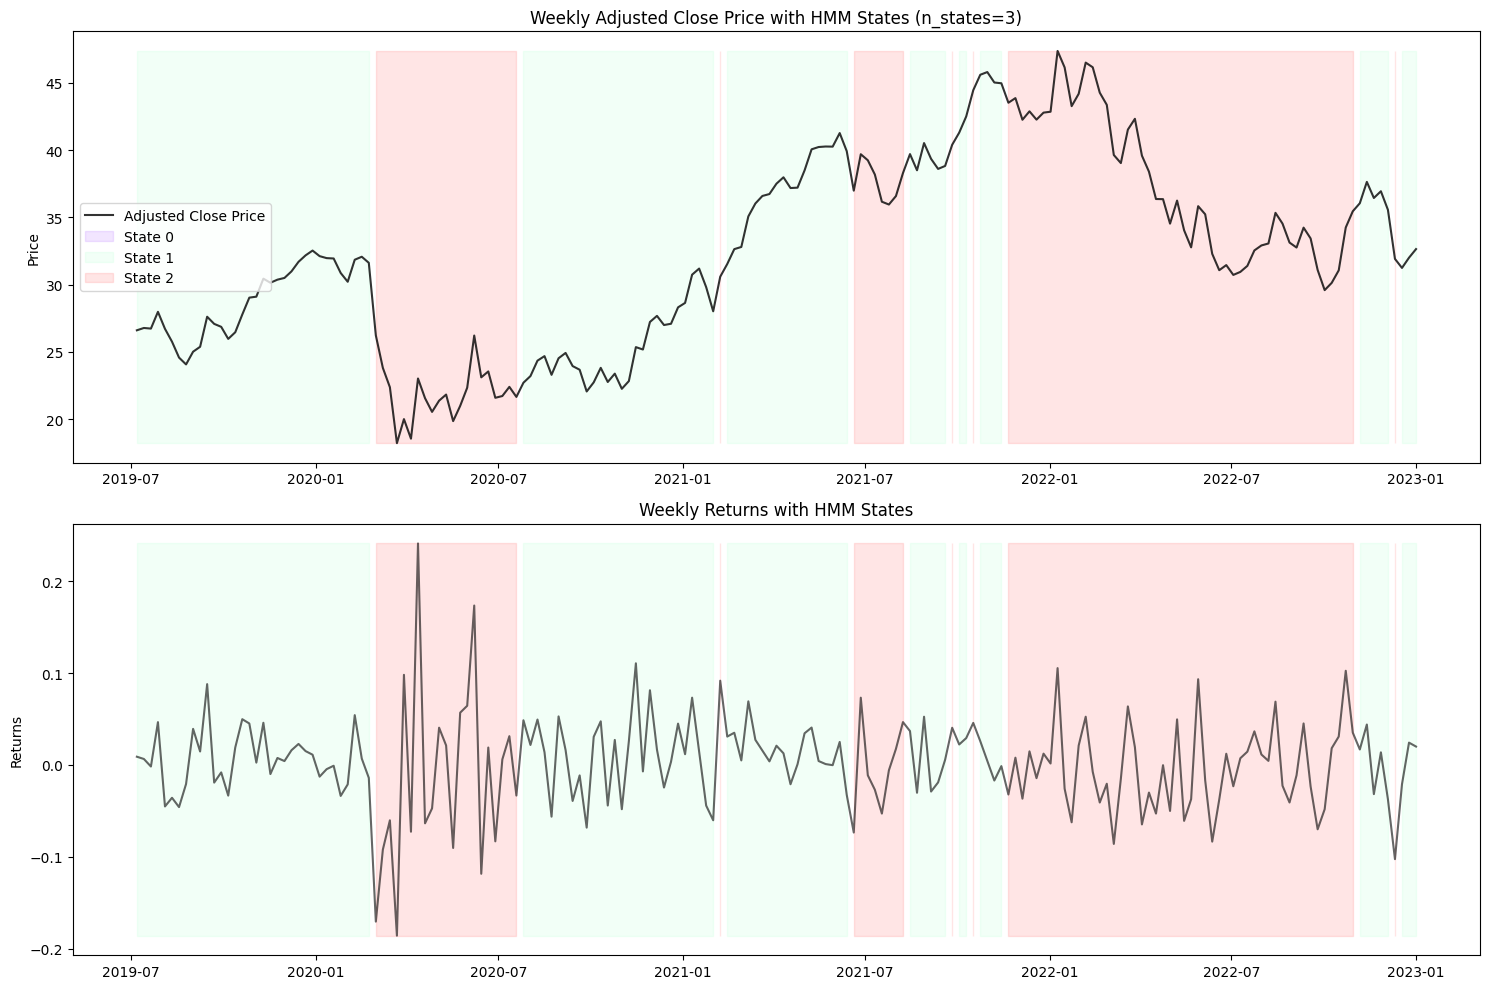

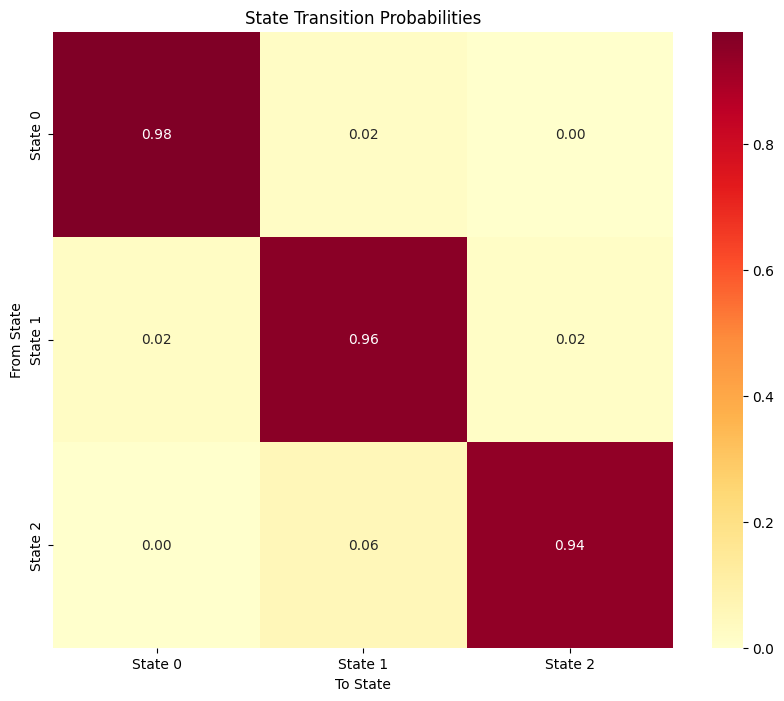


Results for Weekly Prediction (n_states=4):

Training Set Metrics:
Accuracy: 53.08%
Precision: 51.81%
Recall: 90.16%
F1_score: 65.80%

Test Set Metrics:
Accuracy: 61.20%
Precision: 65.69%
Recall: 65.05%
F1_score: 65.37%

Predicted Direction (Test Set): Up
Confidence: 98.30%

State Analysis (Test Set):
State 0 Average Return: nan%
State 1 Average Return: 0.74%
State 2 Average Return: 10.83%
State 3 Average Return: -1.12%


<Figure size 1500x1000 with 0 Axes>

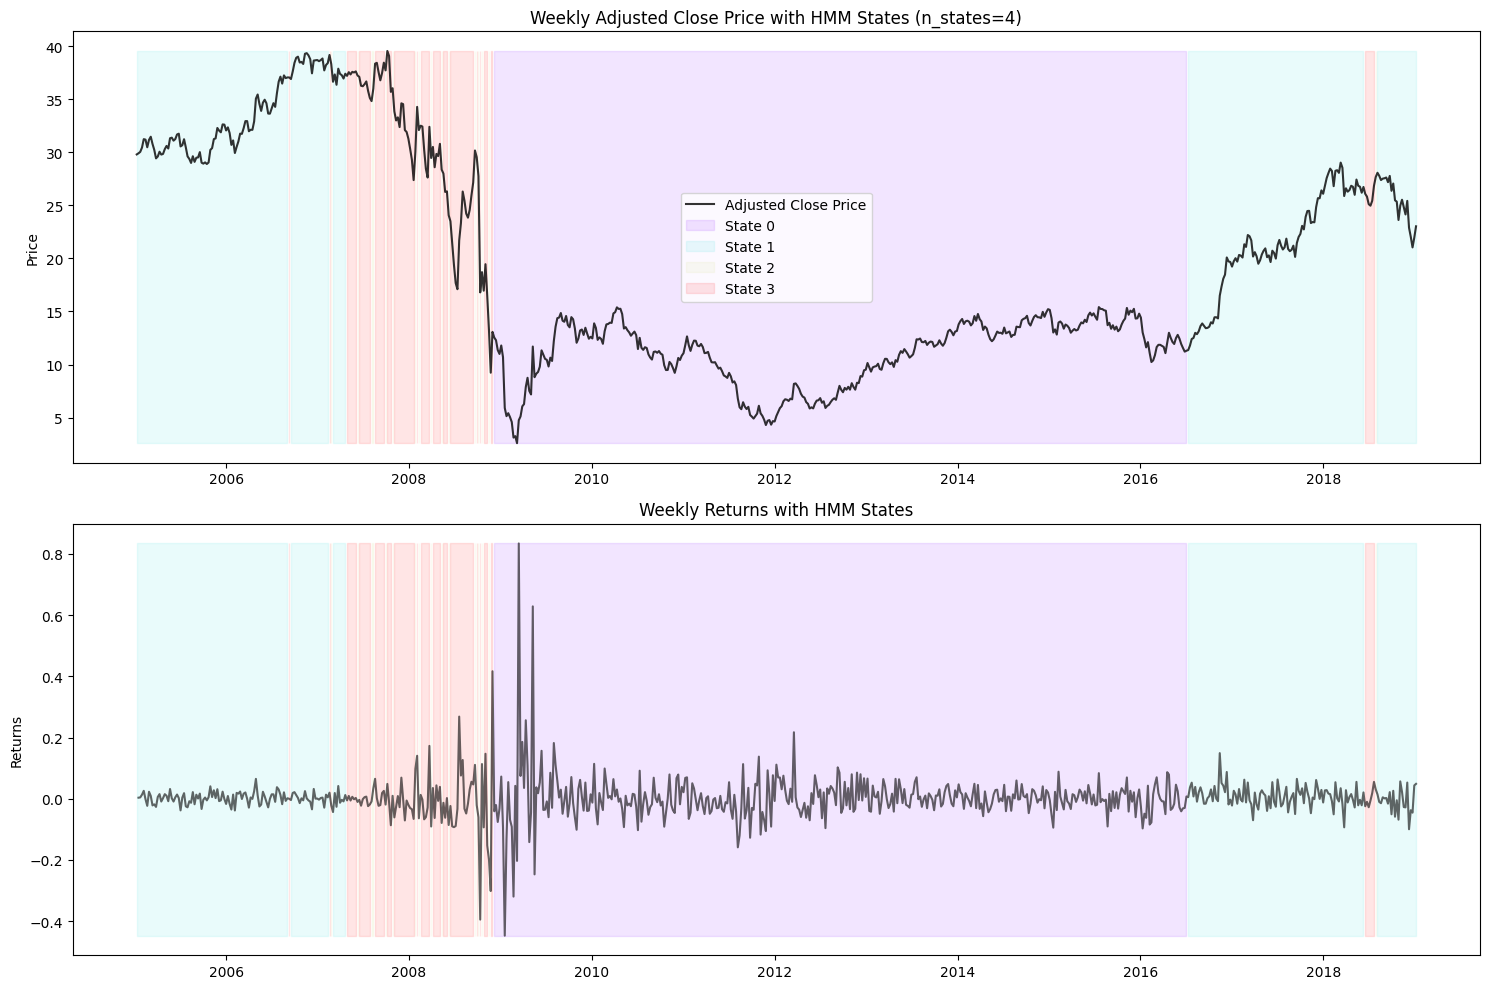

<Figure size 1500x1000 with 0 Axes>

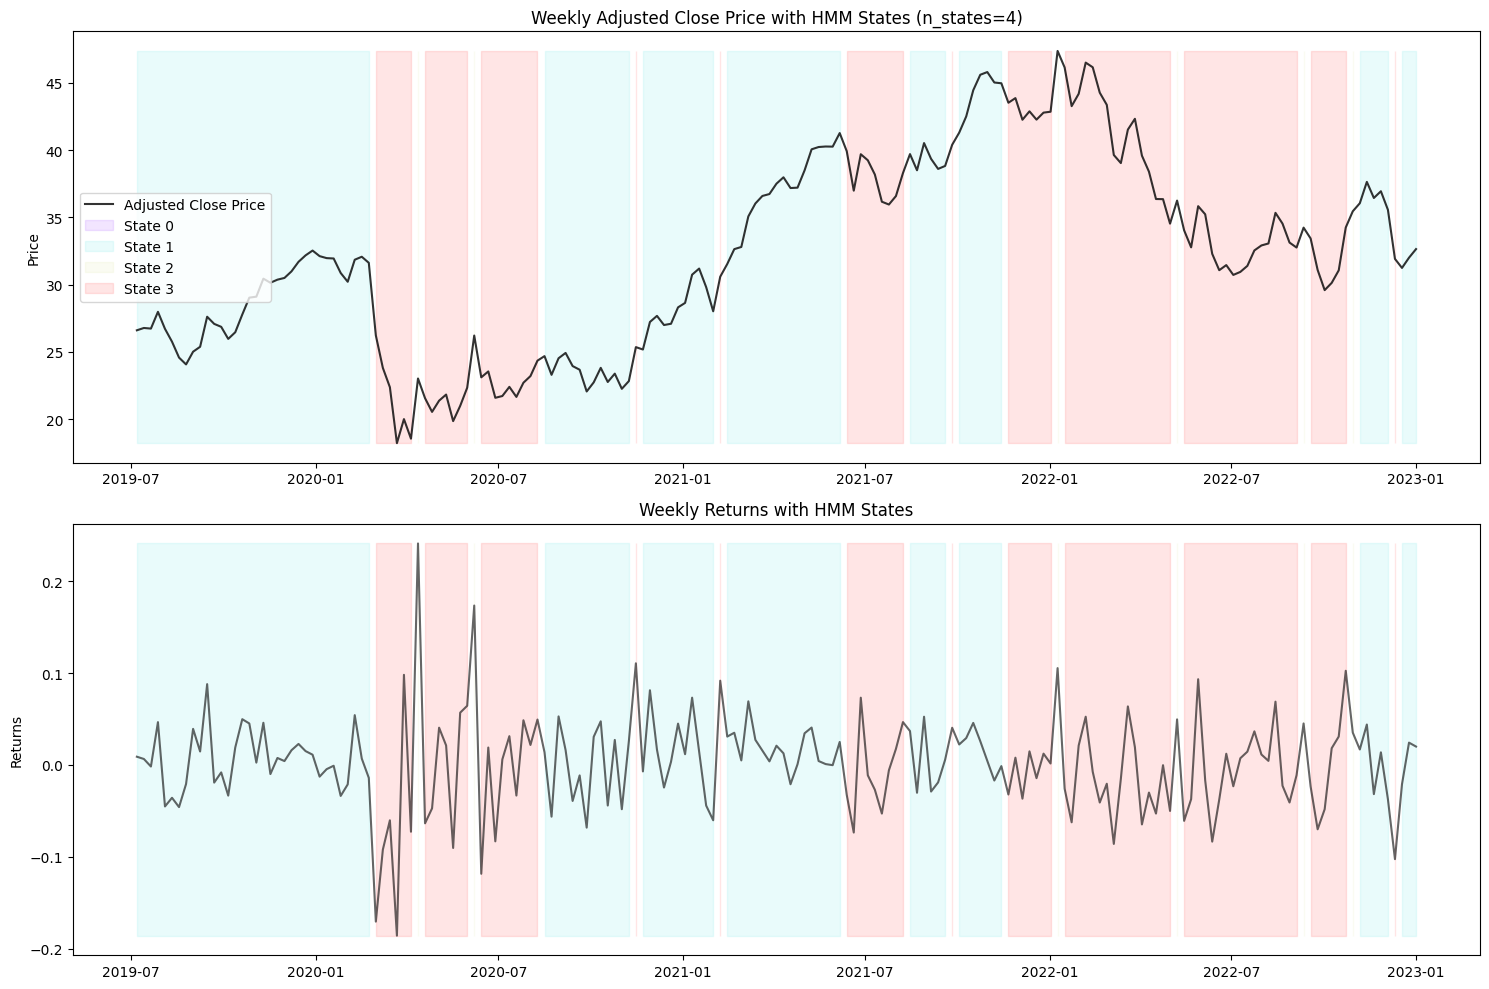

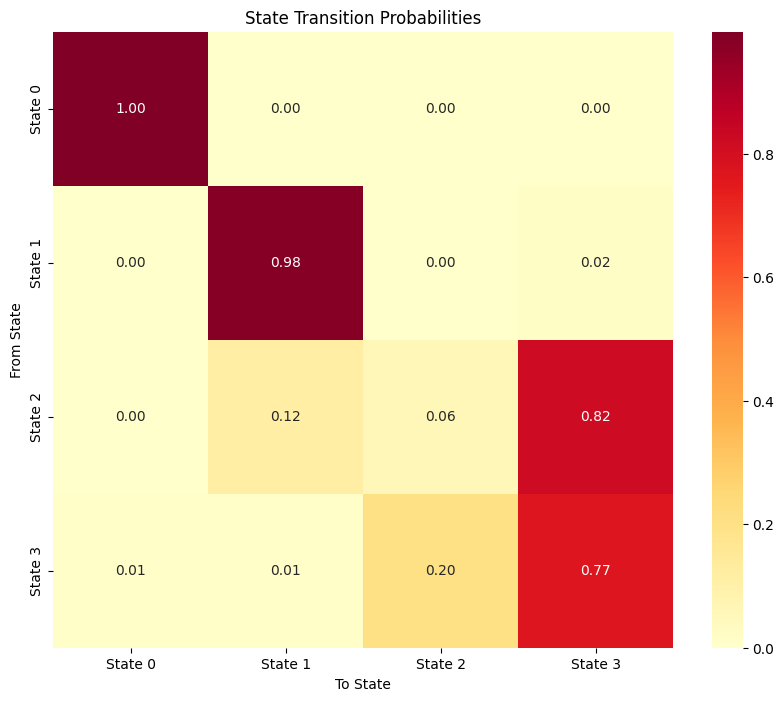


Model Comparison (Test Set Metrics):

Accuracy Comparison:
daily_2_states: 51.22%
daily_3_states: 55.65%
daily_4_states: 51.33%
weekly_2_states: 56.28%
weekly_3_states: 59.02%
weekly_4_states: 61.20%


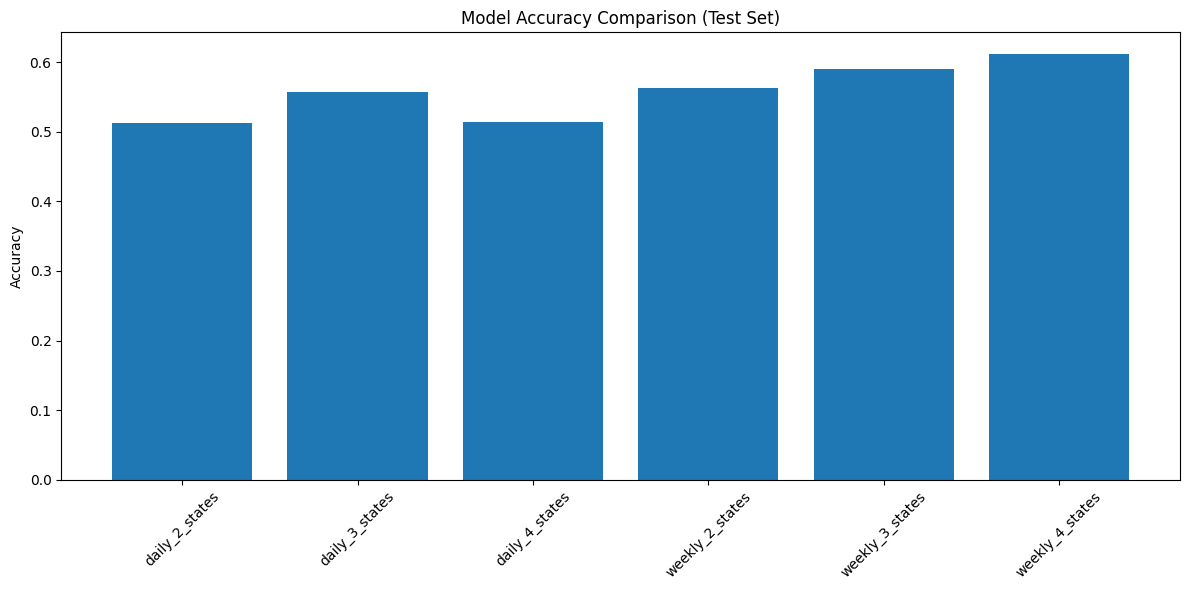

In [27]:
model_results = {}

# Try different numbers of states for daily prediction
for n_states in [2, 3, 4]:
    model_results[f'daily_{n_states}_states'] = evaluate_predictions(data, "daily", n_states, w_indicators=True)

# Try different numbers of states for weekly prediction
for n_states in [2, 3, 4]:
    model_results[f'weekly_{n_states}_states'] = evaluate_predictions(data, "weekly", n_states,  w_indicators=True)

# Compare models
print("\nModel Comparison (Test Set Metrics):")
print("\nAccuracy Comparison:")
for model_name, results in model_results.items():
    print(f"{model_name}: {results['test_metrics']['accuracy']:.2%}")

# Create comparison plot
plt.figure(figsize=(12, 6))
accuracies = [results['test_metrics']['accuracy'] for results in model_results.values()]
model_names = list(model_results.keys())

plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison (Test Set)')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [33]:
def calculate_cumulative_accuracy(hidden_states, df, window_size=50):
    """
    Calculate cumulative and rolling accuracy over time
    """
    # Align returns with hidden states
    returns = df['Returns'].iloc[-len(hidden_states):]
    actual_directions = (returns > 0).astype(int)
    
    # Get state-wise average returns
    unique_states = np.unique(hidden_states)
    state_directions = {}
    
    for state in unique_states:
        mask = hidden_states == state
        state_returns_mean = returns[mask].mean()
        state_directions[state] = 1 if state_returns_mean > 0 else 0
    
    predicted_directions = np.array([state_directions.get(state, 0) for state in hidden_states])
    
    # Calculate cumulative accuracy
    correct_predictions = predicted_directions == actual_directions
    cumulative_accuracy = np.cumsum(correct_predictions) / np.arange(1, len(correct_predictions) + 1)
    
    # Calculate rolling accuracy
    rolling_accuracy = pd.Series(correct_predictions).rolling(window=window_size, min_periods=1).mean()
    
    return cumulative_accuracy, rolling_accuracy, correct_predictions

def plot_cumulative_accuracy(results, window_size=50):
    """
    Plot cumulative and rolling accuracy for test set
    """
    # Get test set predictions and actual values
    hidden_states = results['test_hidden_states']
    df_test = results['df_test']
    
    # Calculate accuracies
    cumulative_accuracy, rolling_accuracy, correct_predictions = calculate_cumulative_accuracy(
        hidden_states, df_test, window_size
    )
    
    # Create plot
    plt.figure(figsize=(15, 10))
    
    # Plot cumulative accuracy
    plt.plot(df_test.index[-len(hidden_states):], 
             cumulative_accuracy, 
             label='Cumulative Accuracy', 
             linewidth=2)
    
    # Plot rolling accuracy
    plt.plot(df_test.index[-len(hidden_states):], 
             rolling_accuracy, 
             label=f'{window_size}-Day Rolling Accuracy', 
             linewidth=2)
    
    # Add horizontal line for overall accuracy
    overall_accuracy = np.mean(correct_predictions)
    plt.axhline(y=overall_accuracy, 
                color='r', 
                linestyle='--', 
                label=f'Overall Accuracy: {overall_accuracy:.2%}')
    
    plt.title('Accuracy Over Time in Test Set')
    plt.xlabel('Date')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return cumulative_accuracy, rolling_accuracy, correct_predictions

def evaluate_predictions_with_cumulative(data, prediction_type="daily", n_states=2, test_size=0.2, w_indicators=False, window_size=50, visualize = False):
    # Run original evaluation
    results = evaluate_predictions(data, prediction_type, n_states, test_size, w_indicators, visualize)
    
    # Check if evaluate_predictions returned the expected keys
    if 'test_hidden_states' not in results or 'df_test' not in results:
        raise KeyError("evaluate_predictions did not return the expected keys ('test_hidden_states', 'df_test')")
    
    # Add cumulative accuracy analysis
    print("\nCalculating Cumulative Accuracy Metrics...")
    cumulative_accuracy, rolling_accuracy, correct_predictions = plot_cumulative_accuracy(results, window_size)
    
    # Add the accuracy information to results
    results.update({
        'cumulative_accuracy': cumulative_accuracy,
        'rolling_accuracy': rolling_accuracy,
        'correct_predictions': correct_predictions
    })
    
    # Print additional statistics
    print("\nCumulative Accuracy Analysis:")
    print(f"First Month Accuracy: {cumulative_accuracy[window_size]:.2%}")
    print(f"Mid-Period Accuracy: {cumulative_accuracy[len(cumulative_accuracy)//2]:.2%}")
    print(f"Final Accuracy: {cumulative_accuracy[-1]:.2%}")
    
    # Print rolling accuracy statistics
    print(f"\nRolling {window_size}-Day Accuracy Range:")
    print(f"Min: {rolling_accuracy.min():.2%}")
    print(f"Max: {rolling_accuracy.max():.2%}")
    print(f"Mean: {rolling_accuracy.mean():.2%}")
    
    return results


Evaluating model with 2 states...

Results for Daily Prediction (n_states=2):

Training Set Metrics:
Accuracy: 51.82%
Precision: 50.86%
Recall: 82.41%
F1_score: 62.90%

Test Set Metrics:
Accuracy: 51.21%
Precision: 51.21%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 93.14%

State Analysis (Test Set):
State 0 Average Return: 0.00%
State 1 Average Return: 0.11%

Calculating Cumulative Accuracy Metrics...

Cumulative Accuracy Analysis:
First Month Accuracy: 47.06%
Mid-Period Accuracy: 53.30%
Final Accuracy: 51.21%

Rolling 50-Day Accuracy Range:
Min: 0.00%
Max: 70.00%
Mean: 50.92%

Evaluating model with 3 states...

Results for Daily Prediction (n_states=3):

Training Set Metrics:
Accuracy: 50.63%
Precision: 50.11%
Recall: 90.42%
F1_score: 64.48%

Test Set Metrics:
Accuracy: 53.53%
Precision: 52.95%
Recall: 83.19%
F1_score: 64.71%

Predicted Direction (Test Set): Up
Confidence: 78.15%

State Analysis (Test Set):
State 0 Average Return: 0.12%
State 1 Av

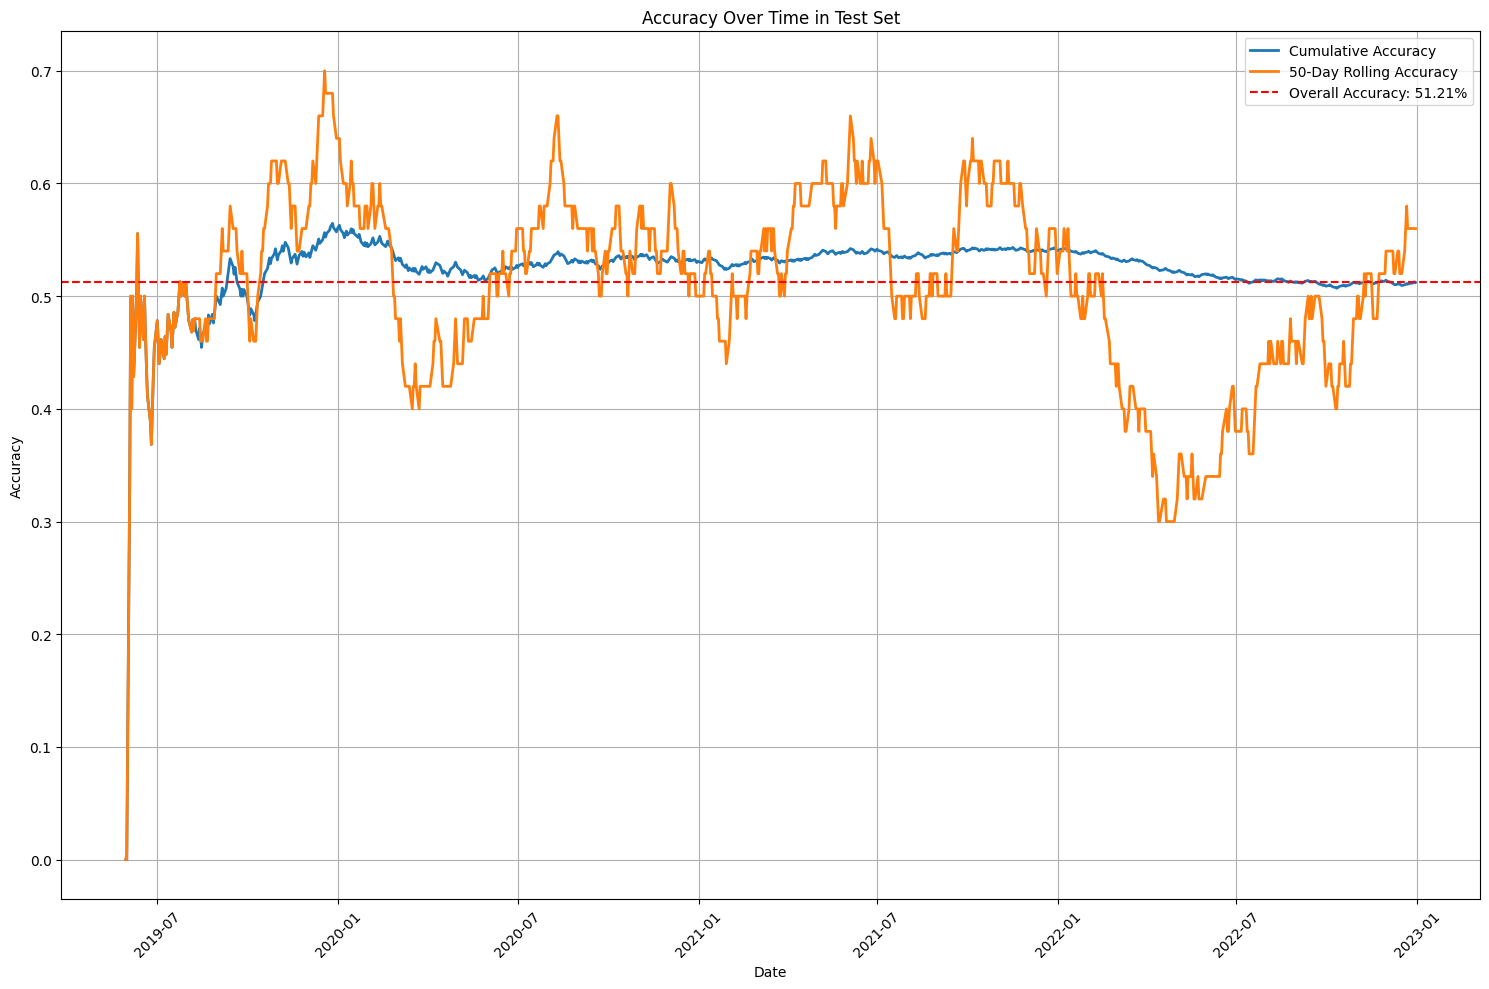

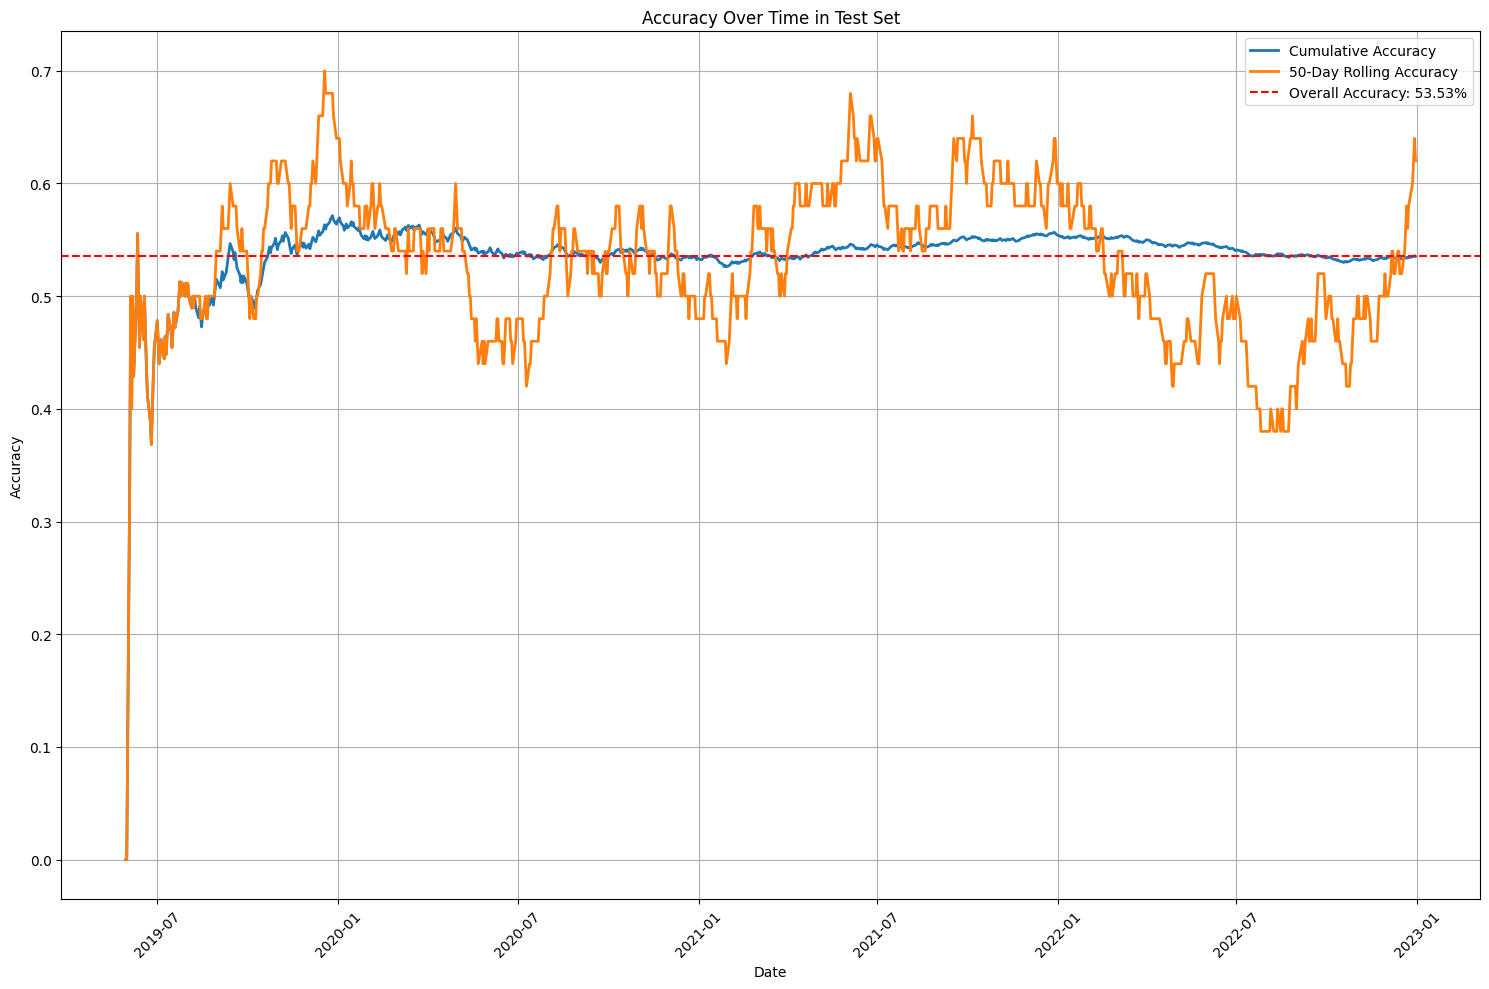

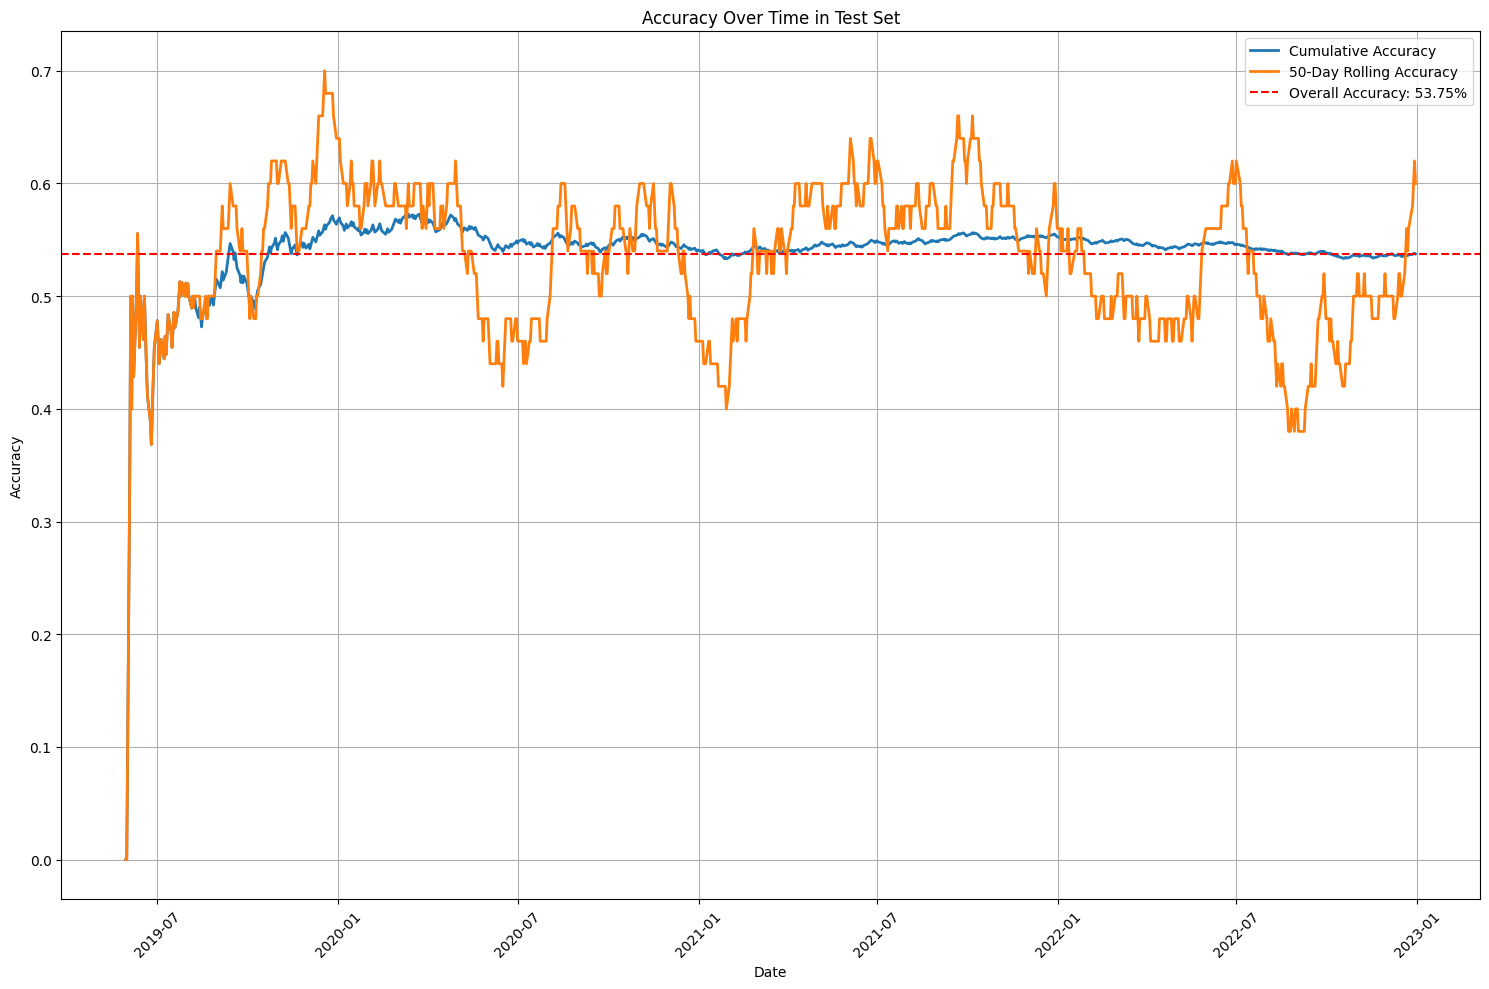

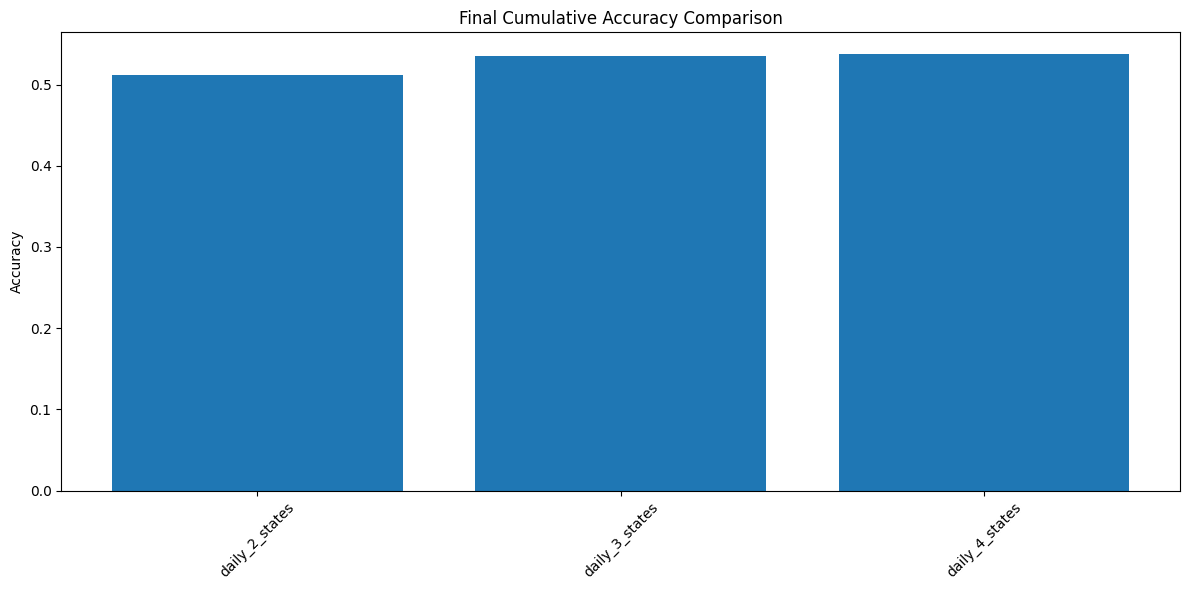


Evaluating model with 2 states...

Results for Daily Prediction (n_states=2):

Training Set Metrics:
Accuracy: 51.47%
Precision: 50.72%
Recall: 81.01%
F1_score: 62.38%

Test Set Metrics:
Accuracy: 51.22%
Precision: 51.22%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 84.95%

State Analysis (Test Set):
State 0 Average Return: 0.01%
State 1 Average Return: 0.13%

Calculating Cumulative Accuracy Metrics...

Cumulative Accuracy Analysis:
First Month Accuracy: 45.10%
Mid-Period Accuracy: 53.32%
Final Accuracy: 51.22%

Rolling 50-Day Accuracy Range:
Min: 0.00%
Max: 70.00%
Mean: 50.96%

Evaluating model with 3 states...

Results for Daily Prediction (n_states=3):

Training Set Metrics:
Accuracy: 51.36%
Precision: 50.60%
Recall: 86.65%
F1_score: 63.89%

Test Set Metrics:
Accuracy: 55.65%
Precision: 55.24%
Recall: 70.78%
F1_score: 62.05%

Predicted Direction (Test Set): Up
Confidence: 97.26%

State Analysis (Test Set):
State 0 Average Return: -0.12%
State 1 A

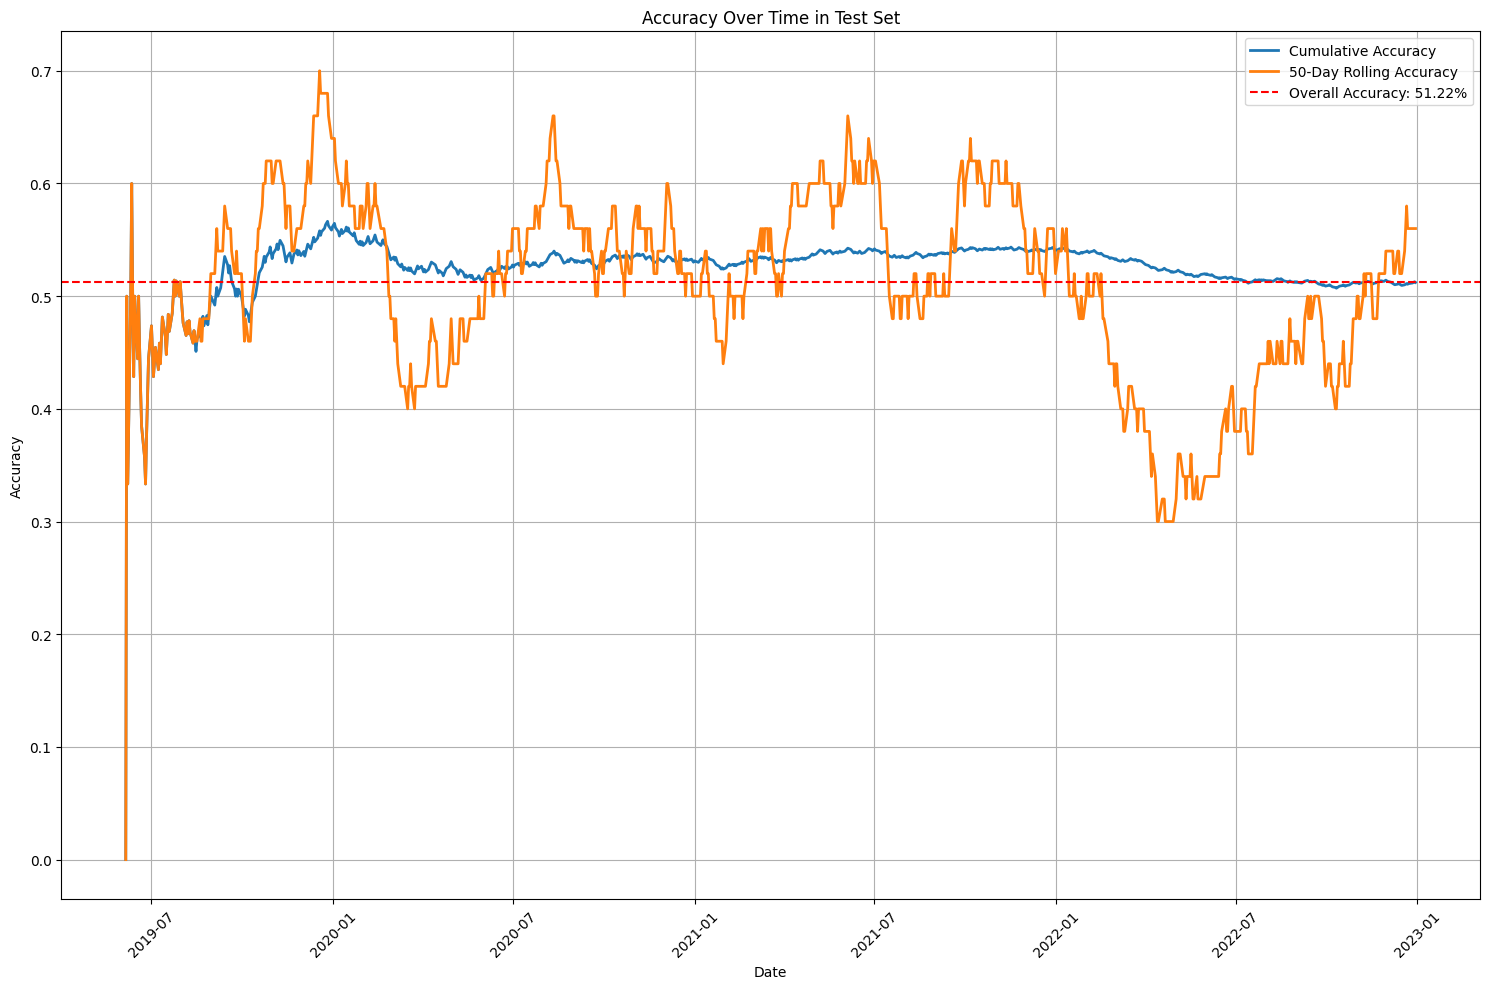

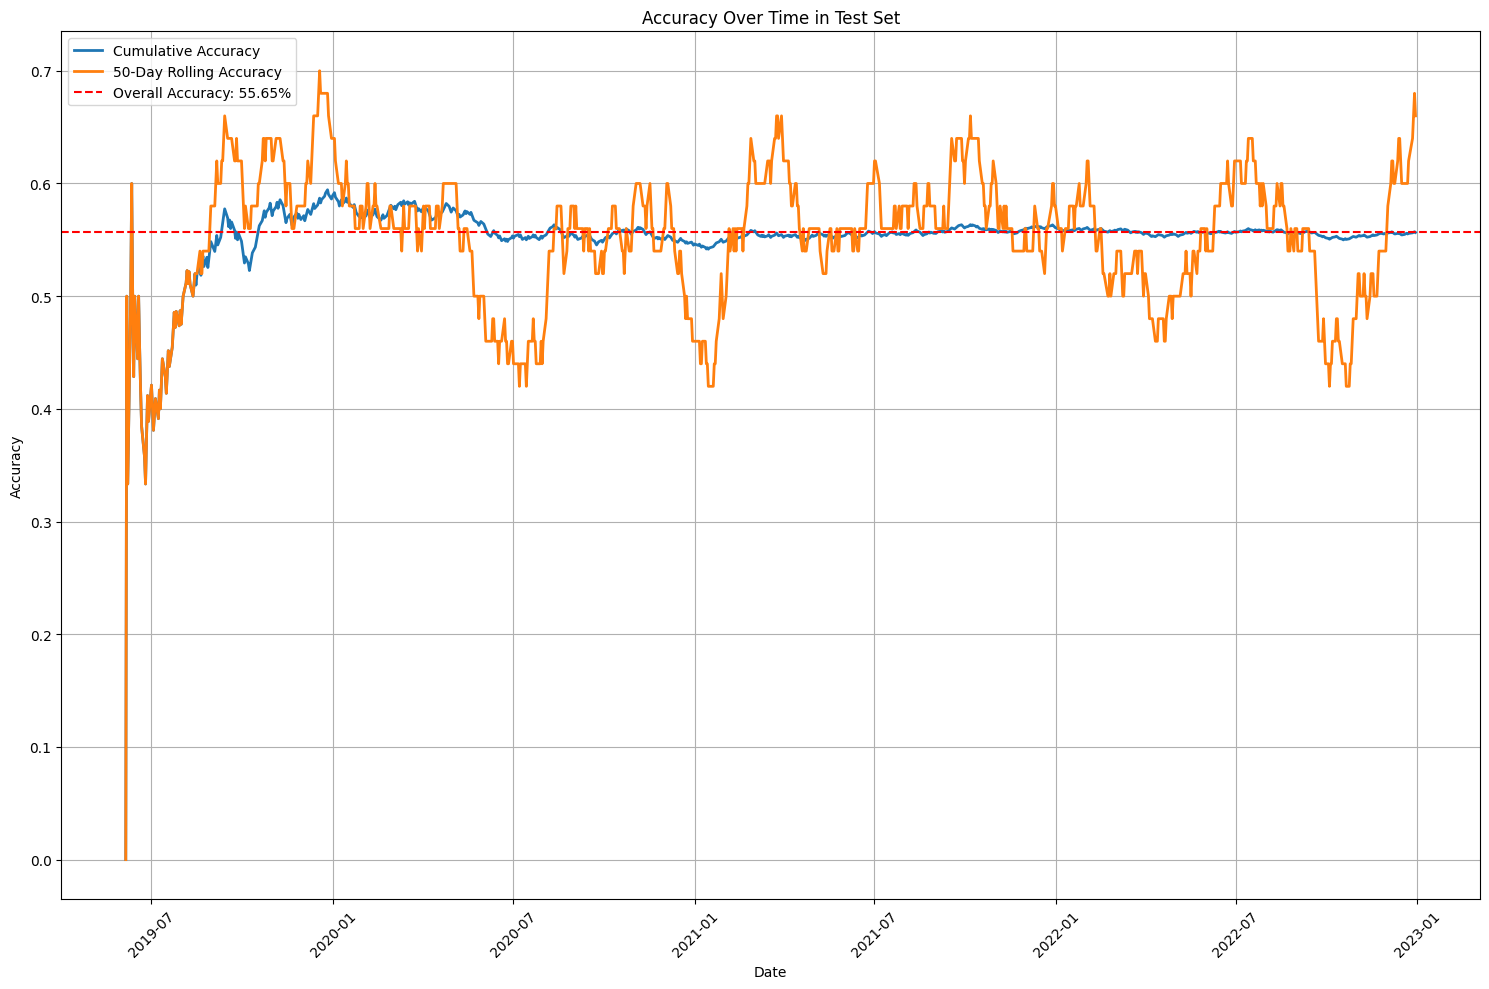

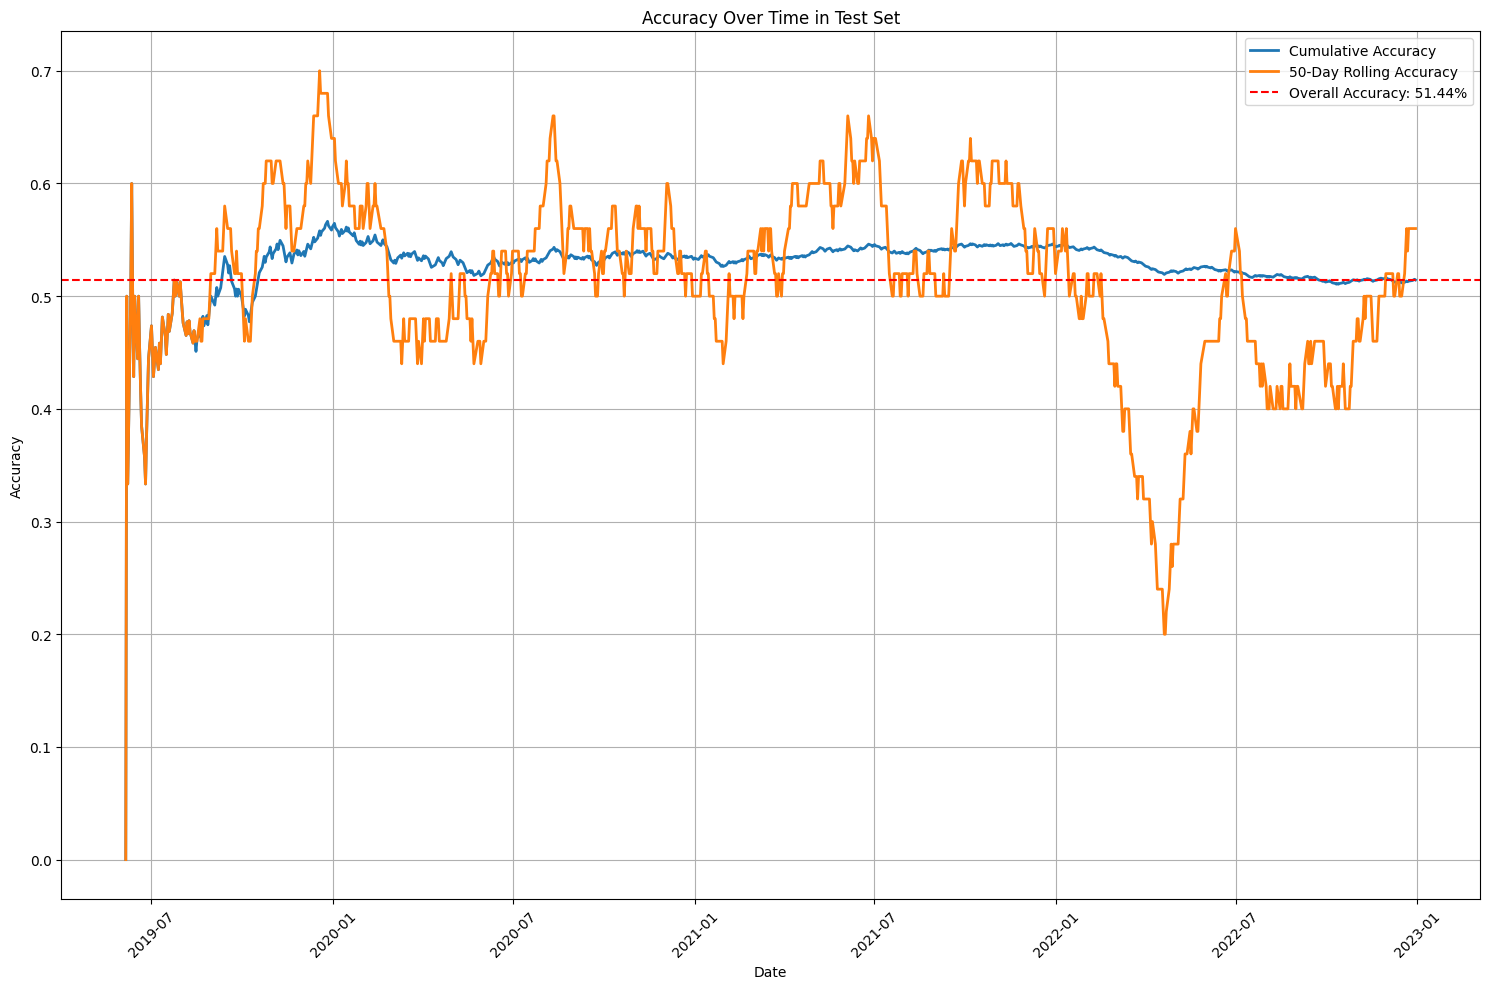

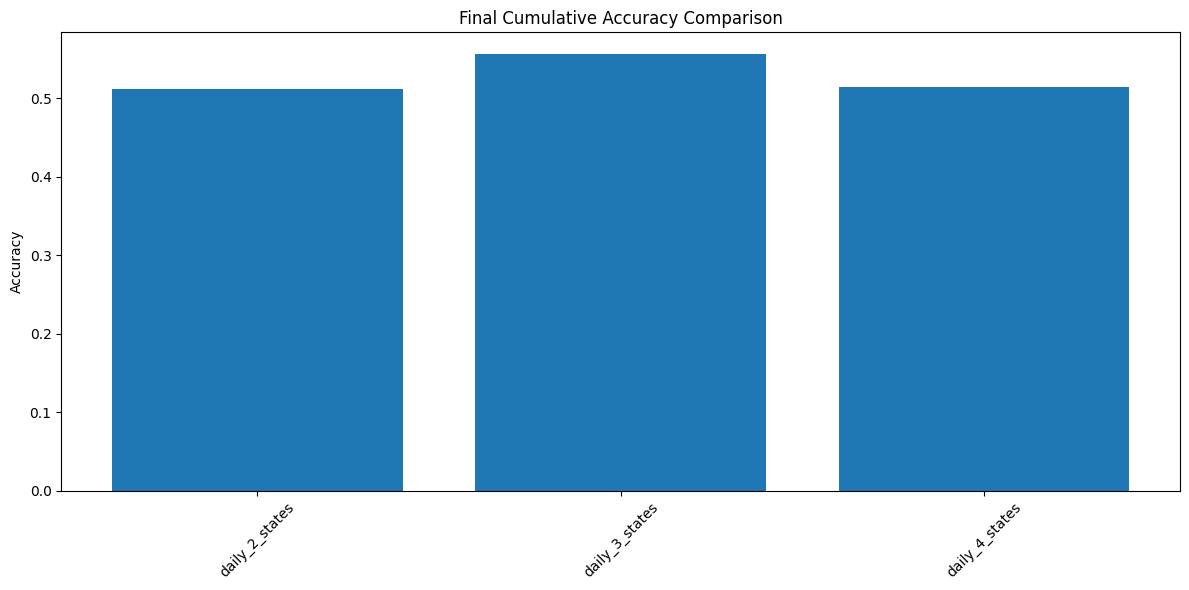

In [34]:
model_results = {}

for n_states in [2, 3 ,4]:
    print(f"\nEvaluating model with {n_states} states...")
    model_results[f'daily_{n_states}_states'] = evaluate_predictions_with_cumulative(
        data, 
        "daily", 
        n_states, 
        test_size=0.2, 
        window_size=50
    )

# Compare final accuracies
plt.figure(figsize=(12, 6))
final_accuracies = [results['cumulative_accuracy'][-1] for results in model_results.values()]
model_names = list(model_results.keys())
plt.bar(model_names, final_accuracies)
plt.title('Final Cumulative Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

for n_states in [2, 3, 4]:
    print(f"\nEvaluating model with {n_states} states...")
    model_results[f'daily_{n_states}_states'] = evaluate_predictions_with_cumulative(
        data, 
        "daily", 
        n_states, 
        test_size=0.2,
        w_indicators=True, 
        window_size=50
    )

# Compare final accuracies
plt.figure(figsize=(12, 6))
final_accuracies = [results['cumulative_accuracy'][-1] for results in model_results.values()]
model_names = list(model_results.keys())
plt.bar(model_names, final_accuracies)
plt.title('Final Cumulative Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()